In [1]:
working_dimers = ['CSD20', 'CSD23', 'CSD25', 'CSD26']

with open('../af2/good_models.list', 'r') as f:
    good_models = f.read().splitlines()

# working_models = [x for x in good_models if x.split('/')[-1][:5] in working_dimers]

working_models = []

for working_dimer in working_dimers:
    models_all = [x for x in good_models if x.split('/')[-1][:5] == working_dimer]
    models_A = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'A_')]
    models_B = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'B_')]
    models_AB = [x for x in models_all if x.split('/')[-1].startswith(working_dimer + 'AB_')]

    working_models.append([models_A, models_B, models_AB, models_AB])

In [2]:
import pyrosetta
pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
}})

In [4]:
# make all combinations of backbones from different AF2 models for each SEC-validated heterodimer
# this will provide MPNN with a good set of backbone diversity for MSD

from itertools import product
from copy import deepcopy

import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.protocols.states import yeet_pose_xyz

sw = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
sw.chain_order('123456')

for models_A_B_AB, working_dimer in zip(working_models, working_dimers):

    poses_A_B_AB = []
    for model_group, yeet_coords, split in zip(models_A_B_AB, [(1,0,0), (0,1,0), (-1,0,0), (0,-1,0)], [False,False,True,True]):
        pose_group = []
        for pdb_fname in model_group:
            pose = pyrosetta.pose_from_pdb(pdb_fname)
            model_num = pdb_fname.split('/')[-1].split('_')[2]

            if yeet_coords:
                pose = yeet_pose_xyz(pose, yeet_coords)

            if split:
                pose = pose.split_by_chain()

            pose_group.append((pose, model_num))
        poses_A_B_AB.append(pose_group)

    for (pose_A, model_A), (pose_B, model_B), (poses_AB_1, model_AB_1), (poses_AB_2, model_AB_2) in product(*poses_A_B_AB):
        combined_pose = deepcopy(pose_A)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(pose_B), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_1[2]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[1]), True)
        pyrosetta.rosetta.core.pose.append_pose_to_pose(combined_pose, deepcopy(poses_AB_2[2]), True)
        sw.apply(combined_pose)
        combined_pose.dump_pdb('01_backbone_combos/' + working_dimer + '_' + model_A + model_B + model_AB_1 + model_AB_2 + '.pdb')

In [2]:
from glob import glob
with open('01_backbone_combos.list', 'w') as f:
    for bb_combo_fname in glob('/home/broerman/projects/CSD/round_2/mpnn_upweight_int/01_backbone_combos/*.pdb'):
        f.write(bb_combo_fname + '\n')

#### Run MPNN on the state combinations ####

In [4]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')

from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "02_mpnn_upweight_int"
design_list_file = "/home/broerman/projects/CSD/round_2/mpnn_upweight_int/01_backbone_combos.list"
output_path = f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{simulation_name}"

options = " ".join(
    [
        "out:level 200",
    ]
)

extra_kwargs = {
    "num_sequences": "10",
    "batch_size" = "10",
    "mpnn_temperature": 0.2,
    "mpnn_design_area": "scan",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.mpnn.mpnn_dimers",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="12G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-287 /home/broerman/projects/CSD/round_2/mpnn_upweight_int/02_mpnn_upweight_int/run.sh


#### Collect scorefiles of the MPNN designed paired states and concatenate ####

In [5]:
import os
from crispy_shifty.utils.io import collect_score_file

simulation_name = "02_mpnn_upweight_int"
output_path = f"/home/broerman/projects/CSD/round_2/mpnn_upweight_int/{simulation_name}"

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

#### Load resulting concatenated scorefile ####

In [6]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

100%|██████████| 861/861 [00:03<00:00, 229.05it/s]


#### Save individual fastas ####

In [7]:
from crispy_shifty.utils.io import df_to_fastas

scores_df = df_to_fastas(scores_df, prefix="mpnn_seq")

100%|██████████| 861/861 [00:02<00:00, 374.08it/s]


#### Save a list of outputs ####

In [9]:
from tqdm.auto import tqdm
with open(os.path.join(output_path, "mpnn_paired_states.list"), "w") as f:
    for path in tqdm(scores_df.index):
        print(path, file=f)

100%|██████████| 861/861 [00:00<00:00, 1119434.51it/s]


#### Concat the pdb.bz2 and fasta paths into a single list, for Superfold reasons ####

In [10]:
with open(os.path.join(output_path, "mpnn_paired_states.pair"), "w") as f:
    for path in tqdm(scores_df.index):
        line = path + "____" + path.replace("decoys", "fastas").replace("pdb.bz2", "fa")
        print(line, file=f)

100%|██████████| 861/861 [00:00<00:00, 745057.92it/s]


Go fold on perlmutter

### Collect scorefiles of the folded paired state Ys and concatenate

In [1]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO might have to switch to a dask accelerated approach for production

In [3]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
100%|██████████| 38745/38745 [02:44<00:00, 235.51it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [4]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores_old.csv"))

In [5]:
# mpnn scores were accidentally not included in the folding function
# get them from the original files

sbatch_fname = 'fix_scores'

from glob import glob

task_lines = []

for out_dir in sorted(glob("/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/decoys/*")):
    task_lines.append(f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.py {out_dir.split('/')[-1]}\n")

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p short
#SBATCH -c 1
#SBATCH --mem=3G

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat fix_scores.tasks | wc -l) fix_scores.sh


In [12]:
import pandas as pd
import os
simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
scores_df_old = pd.read_csv(os.path.join(output_path, "scores_old.csv"), index_col="Unnamed: 0")

In [13]:
# add mpnn scores to scores_df
from glob import glob
mpnn_scores_df = pd.DataFrame()
partial_scores_dfs = []
for partial_scores_csv in glob('03_fold_dimer_Y/fixed_scores/*.csv'):
    partial_scores_df = pd.read_csv(partial_scores_csv, index_col="Unnamed: 0")
    partial_scores_dfs.append(partial_scores_df)
mpnn_scores_df = pd.concat(partial_scores_dfs)
scores_df = pd.concat([scores_df_old, mpnn_scores_df], axis=1)
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

In [35]:
import pandas as pd
import os
simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(scores_df)

,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_dcae11fcc0294da6972ce2090d49518e.pdb.bz2,14.801474,26.694939,26.867767,26.522108,2.862259,3.321629,2.402889,94.724335,3,0.521028,3.0,18.738997,0,0.656156,monomer_ptm,0.0,-3905.187854,1085.734181,-1166.825524,1258.046168,119.705007,3829.081589,2525.253900,-26.121191,-8.596163,-30.703355,-515.972329,-99.174319,63.603676,-203.398954,0.000000,-249.646869,177.77442,-266.487368,2.243906e-07,mpnn,neighborhood,0.2,CSD20,3511,mpnn_seq_0008
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_6add6ae0eb29431f8e853d2beb15bec4.pdb.bz2,3.996412,4.553738,4.499398,4.608078,3.316893,3.393380,3.240405,94.627922,3,0.925066,3.0,0.564629,0,0.070731,monomer_ptm,0.0,-4083.268532,1339.726571,-1257.895707,1243.572939,149.200148,7458.605114,2987.771704,-36.302899,-11.049234,-51.165870,-537.107413,-73.608169,154.214717,-201.880777,10.244930,-261.519341,-118.90736,1849.605825,0.000000e+00,mpnn,neighborhood,0.2,CSD25,4111,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_d8aafe59393f4880b898d0a46555b908.pdb.bz2,14.543711,25.826004,25.966635,25.685375,3.210433,3.491144,2.929721,94.572960,5,0.529132,3.0,20.525284,0,2.794697,monomer_ptm,0.0,-4767.368381,1550.511891,-1576.294840,1447.015659,168.802123,4190.159862,3444.078868,-20.794247,-25.474166,-46.437606,-679.981906,-92.156051,117.204168,-265.414412,5.632062,-443.767742,-11.07962,-514.546887,0.000000e+00,mpnn,neighborhood,0.2,CSD26,3532,mpnn_seq_0003
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_6fcbe8e1cc604b069453a382c6b4ae09.pdb.bz2,15.970078,27.512566,27.802898,27.222231,4.382103,5.111536,3.652671,90.677261,5,0.493706,3.0,21.630379,0,1.552238,monomer_ptm,0.0,-4779.449221,1666.366305,-1614.641664,1445.800214,174.153459,6268.880500,3571.160877,-22.988423,-26.190909,-42.906183,-675.927200,-83.354880,137.618665,-241.003193,229.397833,-366.259581,-121.79122,1032.010357,4.566968e-08,mpnn,interface,0.2,CSD26,1322,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_02579a3514284368ae810aaad46fbda1.pdb.bz2,14.713778,26.366798,26.553307,26.180288,3.011329,3.277510,2.745148,95.630501,5,0.527944,3.0,24.077631,0,1.932166,monomer_ptm,0.0,-4789.913374,1621.019615,-1614.291886,1468.767842,174.434412,3889.425408,3495.021311,-23.298367,-27.634465,-48.748310,-683.995306,-92.779310,131.533101,-250.676458,190.803861,-357.478295,-62.61196,-412.728751,0.000000e+00,mpnn,neighborhood,0.2,CSD26,2323,mpnn_seq_0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_555d5134716a48e7a4674f4aac1fc6c1.pdb.bz2,16.436779,28.192448,28.530401,27.854496,4.640957,6.248150,3.033765,93.237251,4,0.516245,3.0,14.036655,0,3.170549,monomer_ptm,0.0,-4864.587932,1578.310754,-1624.272561,1542.392748,175.810987,4001.840646,3491.964291,-26.437248,-26.799869,-52.112730,-694.157293,-86.865914,121.677299,-262.156732,2.784288,-376.386914,120.18436,-548.248934,0.000000e+00,mpnn,full,0.2,CSD26,4111,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_1fbc7ce03dda4f8eb9d7959975059941.pdb.bz2,15.264214,27.481827,27.715408,27.248243,3.033890,3.229624,2.838157,95.564781,3,0.521577,3.0,15.888581,0,4.423999,monomer_ptm,0.0,-4843.463566,1676.507365,-1636.586406,1519.032784,1

### Setup for plotting

In [15]:
import seaborn as sns

sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [6]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"].sample(1000, random_state=0)
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

# sample_df = scores_df.sample(2000, random_state=0)

### Remove score terms we don't care about

In [8]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

2000
['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol', 'Y_type', 'total_score', 'designed_by', 'mpnn_msd_design_area', 'mpnn_msd_temperature']


### Plot AF2 metrics

5it [00:00, 28.56it/s]


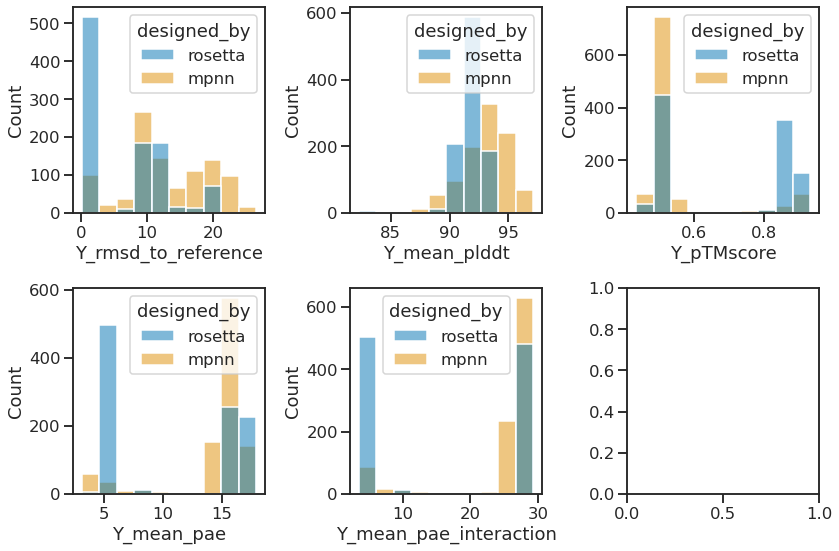

In [14]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1440x1440 with 0 Axes>

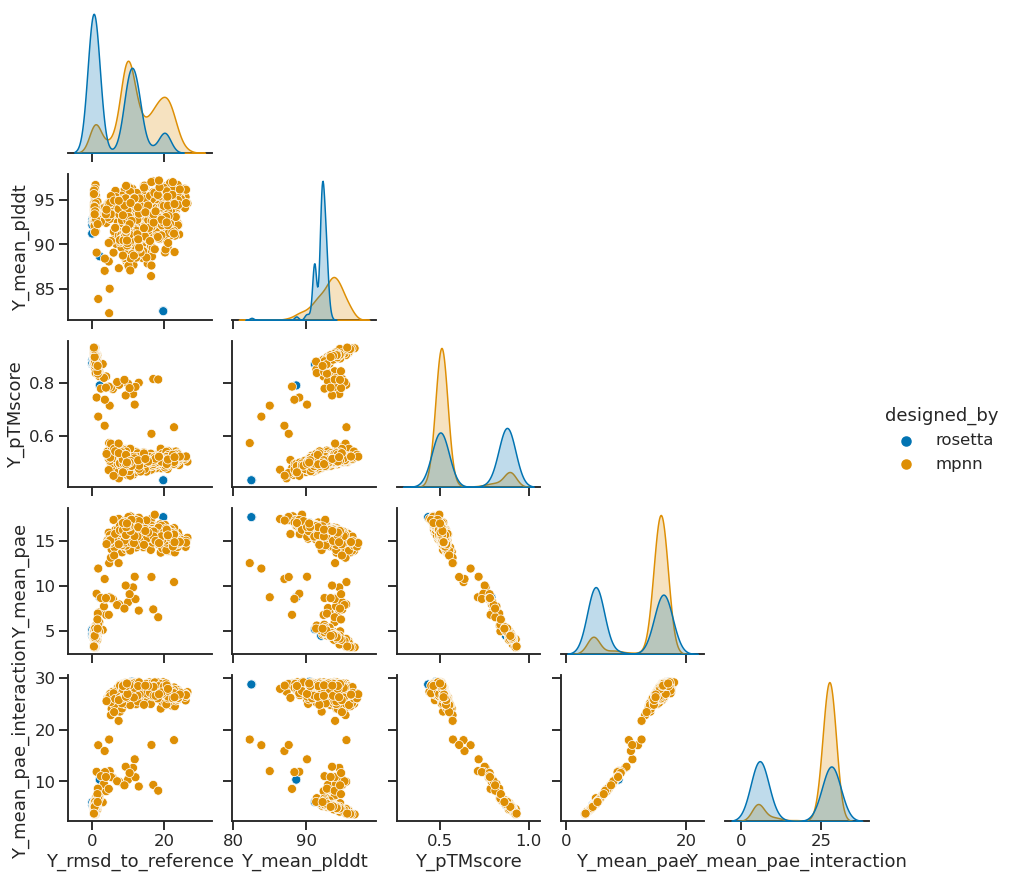

In [15]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Plot effects of MPNN selector areas on AF2 metrics

5it [00:00, 24.40it/s]


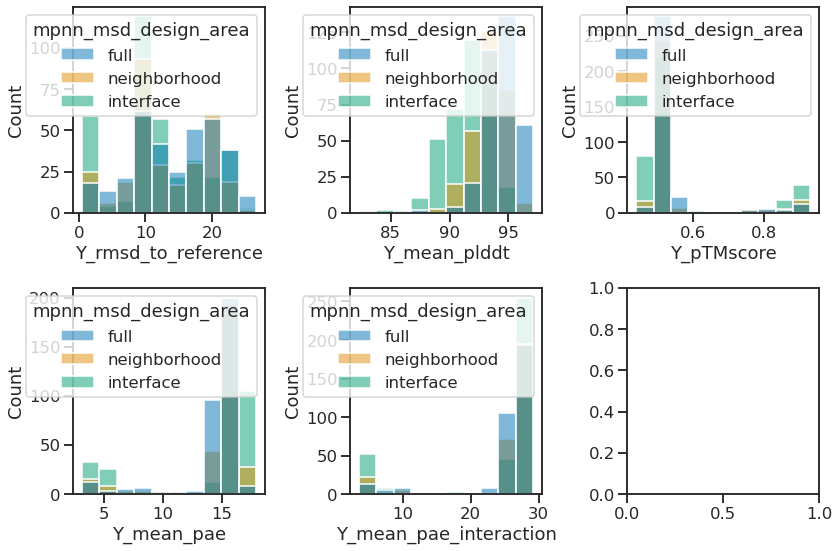

In [18]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

<Figure size 1440x1440 with 0 Axes>

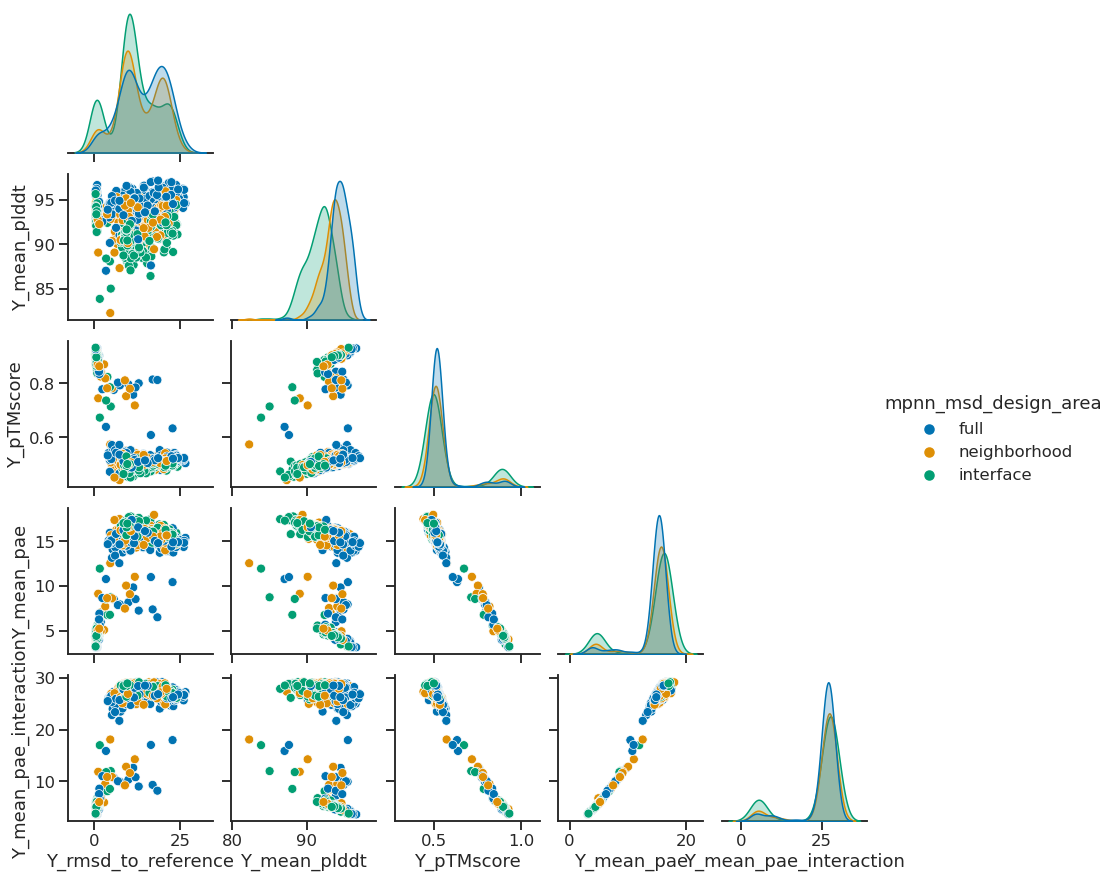

In [19]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

### Filter the whole df

In [36]:
query = "Y_mean_plddt > 90 and Y_mean_pae_interaction < 7 and Y_rmsd_to_reference < 2 and designed_by == 'mpnn'"

filtered = scores_df.query(query)
print(len(filtered))

3014


In [ ]:
import bz2
from glob import glob
with open(sorted(glob('02_mpnn_upweight_int/decoys/0000/*.pdb.bz2'))[0], 'rb') as f:
    print(bz2.decompress(f.read()).decode())

In [ ]:
# import pyrosetta
# import pyrosetta.distributed.cluster as cluster
# from tqdm.auto import tqdm

# for index in tqdm(filtered.index):
#     folded_path = index.replace("/pscratch/sd/b/broerman", "/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int")
#     input_path = pyrosetta.distributed.cluster.get_scores_dict(folded_path)["instance"]["tasks"]["pdb_path"].split('____')[0].replace("/global/u2/b/broerman/projects/CSD", "/home/broerman/crispy_shifty/projects/crispy_shifty_dimers")
#     input_metadata = pyrosetta.distributed.cluster.get_scores_dict(input_path)
#     parent, combo = input_metadata["instance"]["tasks"]["pdb_path"][:-4].split('/')[-1].split('_')
#     filtered.loc[index, "parent"] = parent
#     filtered.loc[index, "combo"] = combo

In [3]:
if not os.path.exists(os.path.join(output_path, "scores_filtered.csv")):
    filtered.to_csv(os.path.join(output_path, "scores_filtered.csv"))

filtered

,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,...,rama_prepro,ref,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_6add6ae0eb29431f8e853d2beb15bec4.pdb.bz2,3.996412,4.553738,4.499398,4.608078,3.316893,3.393380,3.240405,94.627922,3,0.925066,...,-261.519341,-118.90736,1849.605825,0.0,mpnn,neighborhood,0.2,CSD25,4111,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_8a2875727b664d07a3b1d77c2a85102b.pdb.bz2,4.598972,5.277584,5.220522,5.334646,3.791903,3.907250,3.676557,93.106331,4,0.904813,...,-268.044252,-104.70532,723.386933,0.0,mpnn,neighborhood,0.2,CSD25,4111,mpnn_seq_0003
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_a415807429f149a09c274bbb74afc728.pdb.bz2,4.103551,4.630902,4.632281,4.629524,3.450523,3.628355,3.272692,93.970451,1,0.915019,...,-212.307944,-123.83920,1319.433523,0.0,mpnn,neighborhood,0.2,CSD25,3311,mpnn_seq_0003
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_01dabf0a5fc74c48a3d89f6bf2ba3856.pdb.bz2,4.489100,5.153421,5.476701,4.830142,3.727833,4.593922,2.861744,94.675041,1,0.899031,...,-347.364527,-54.94370,-206.122025,0.0,mpnn,neighborhood,0.2,CSD26,2421,mpnn_seq_0002
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0024/03_fold_dimer_Y_d7369499de2e4a46adcf529a84aa5dba.pdb.bz2,3.924131,4.414480,4.583641,4.245318,3.334535,3.740181,2.928889,94.888985,2,0.914791,...,-377.328520,-62.95308,2540.195039,0.0,mpnn,neighborhood,0.2,CSD26,2421,mpnn_seq_0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_4142110003054aeaaa5b70d5441d2e21.pdb.bz2,5.608615,6.645340,7.001579,6.289101,4.516790,6.193873,2.839707,93.844147,4,0.869407,...,-368.280188,37.93944,1299.818848,0.0,mpnn,full,0.2,CSD26,3421,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_c49bdb724ca142f7b4591a1be0dbbf43.pdb.bz2,3.570139,4.093909,4.190710,3.997108,2.966892,3.319373,2.614412,96.335892,3,0.923281,...,-391.762288,129.04694,34.744237,0.0,mpnn,full,0.2,CSD26,4411,mpnn_seq_0005
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_c6a10c9dfd004c4a931ed5922513a2db.pdb.bz2,4.302727,4.997319,5.239915,4.754724,3.561118,4.465580,2.656656,95.382828,3,0.908057,...,-355.997420,37.93944,2536.536769,0.0,mpnn,full,0.2,CSD26,3421,mpnn_seq_0007
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0014/03_fold_dimer_Y_3a6fa9228629499a8fc75c44334fd561.pdb.bz2,3.574596,4.096847,4.254333,3.939360,3.034323,3.481018,2.587628,96.148003,1,0.913266,...,-281.478445,143.56284,1656.892684,0.0,mpnn,full,0.2,CSD26,2332,mpnn_seq_0008


In [4]:
filtered_full = filtered.query("mpnn_msd_design_area == 'full'")
filtered_nbhd = filtered.query("mpnn_msd_design_area == 'neighborhood'")
print(len(filtered_full))
print(len(filtered_nbhd))

cols = [
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_mean_pae",
    "Y_mean_pae_interaction",
]

712
982


<Figure size 1440x1440 with 0 Axes>

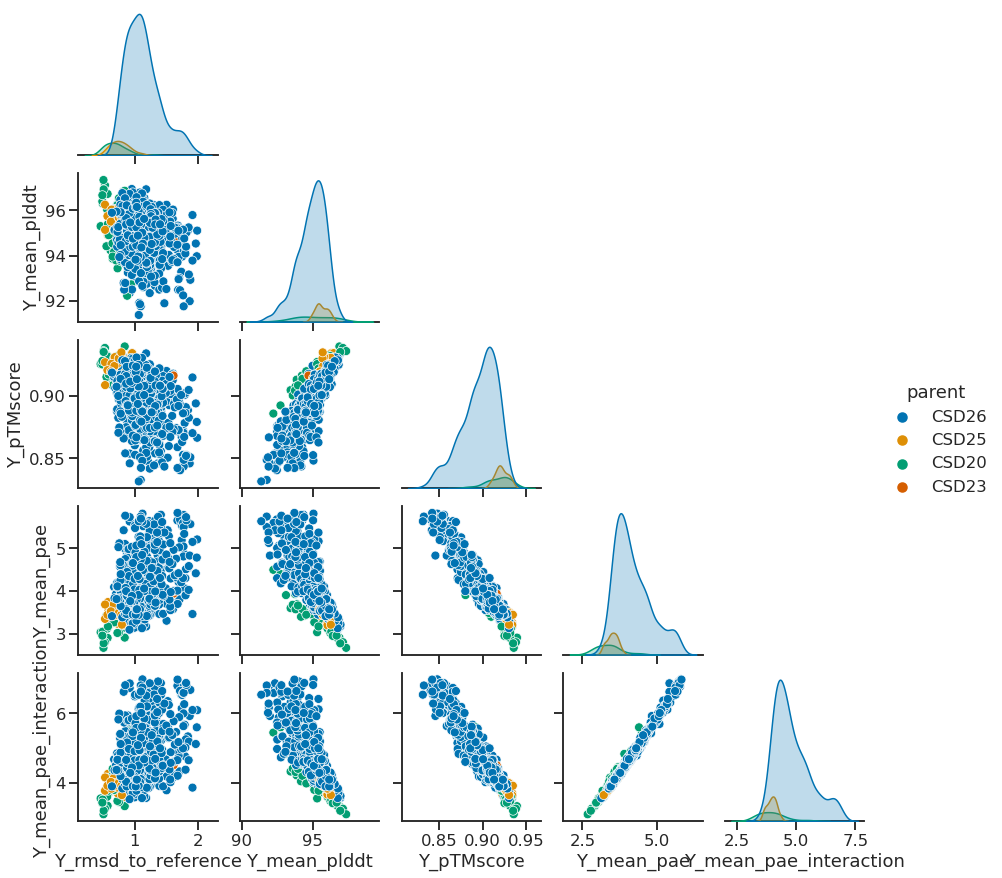

In [19]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

the_fig = pairplot_df(
    df=filtered_full,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

<Figure size 1440x1440 with 0 Axes>

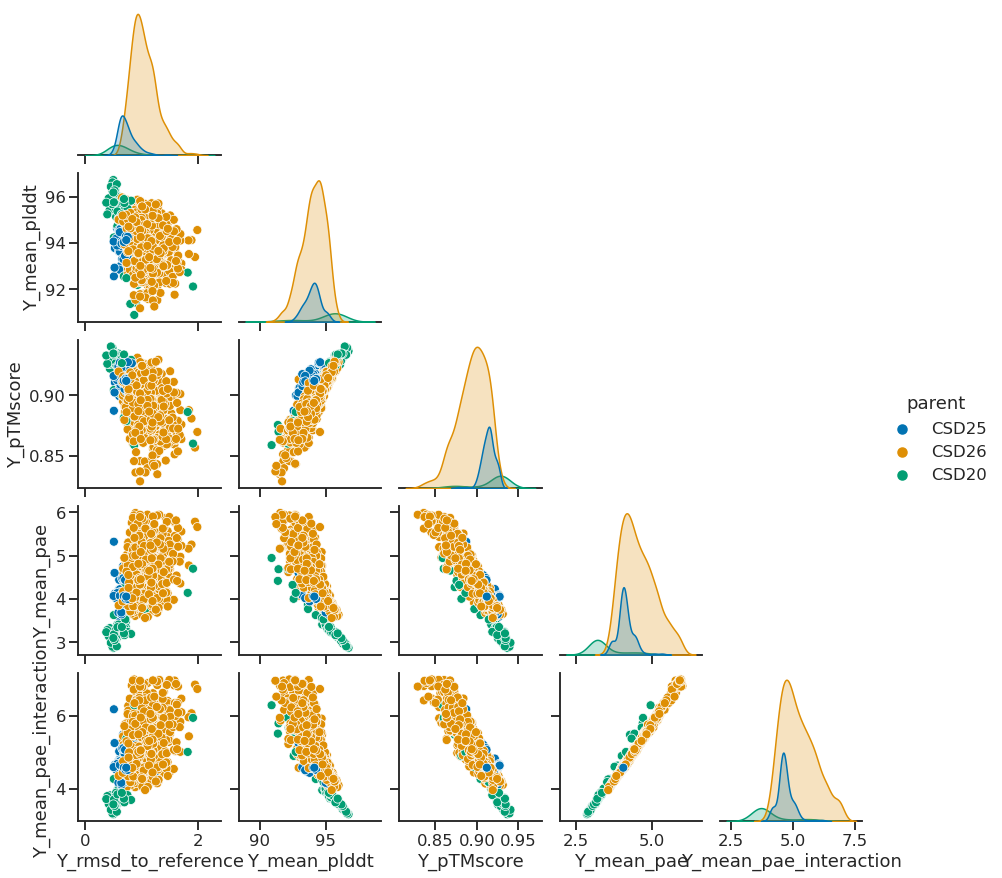

In [20]:
the_fig = pairplot_df(
    df=filtered_nbhd,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [21]:
filtered_full[filtered_full["parent"] == "CSD23"]

,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,...,rama_prepro,ref,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id
/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0028/03_fold_dimer_Y_11d65a69343a41e08b42a1ea6dea35bd.pdb.bz2,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,...,-311.782541,249.94334,156.06052,0.0,mpnn,full,0.2,CSD23,4211,mpnn_seq_0006


In [41]:
# get unique sequences

unique_combos = []

for index, row in filtered.iterrows():
    unique_combo = row["parent"] + "_" + str(row["combo"]) + "_" + row["mpnn_msd_design_area"] + "_" + row["mpnn_seq_id"]
    filtered.loc[index, "unique_combo"] = unique_combo
    unique_combos.append(unique_combo)

unique_df = pd.DataFrame(columns=filtered.columns)
for unique_combo in unique_combos:
    combo_df = filtered.query(f"unique_combo == '{unique_combo}'")
    best_index = combo_df['Y_mean_plddt'].idxmax()
    unique_df.loc[best_index, :] = combo_df.loc[best_index]
    unique_df.loc[best_index, 'num_Y_models'] = len(combo_df)

print(filtered['unique_combo'].nunique())
print(unique_df['unique_combo'].nunique())
unique_df

1495
1495


,Unnamed: 0,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,...,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models
5,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,3.591399,4.049973,4.150271,3.949675,3.013522,3.276638,2.750406,95.339798,5,...,1669.072478,0.0,mpnn,neighborhood,0.2,CSD25,4111,mpnn_seq_0007,CSD25_4111_neighborhood_mpnn_seq_0007,3.0
45,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,3.66138,4.143905,4.245044,4.042767,3.063947,3.343515,2.784379,95.098618,5,...,856.385845,0.0,mpnn,neighborhood,0.2,CSD25,4111,mpnn_seq_0003,CSD25_4111_neighborhood_mpnn_seq_0003,4.0
2,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.103551,4.630902,4.632281,4.629524,3.450523,3.628355,3.272692,93.970451,1,...,1319.433523,0.0,mpnn,neighborhood,0.2,CSD25,3311,mpnn_seq_0003,CSD25_3311_neighborhood_mpnn_seq_0003,1.0
62,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.198759,4.773634,5.117191,4.430078,3.512803,4.188978,2.836628,94.815987,3,...,-80.841857,0.0,mpnn,neighborhood,0.2,CSD26,2421,mpnn_seq_0002,CSD26_2421_neighborhood_mpnn_seq_0002,3.0
72,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,3.862764,4.347239,4.574751,4.119727,3.265528,3.622107,2.908949,95.366524,3,...,1013.417693,0.0,mpnn,neighborhood,0.2,CSD26,2421,mpnn_seq_0003,CSD26_2421_neighborhood_mpnn_seq_0003,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.057505,4.682463,4.735761,4.629164,3.370102,4.045992,2.694213,95.621941,1,...,2570.723328,0.0,mpnn,full,0.2,CSD26,4111,mpnn_seq_0007,CSD26_4111_full_mpnn_seq_0007,1.0
3002,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.812952,5.488636,5.683405,5.293867,4.032035,4.79472,3.269349,93.567192,3,...,476.492856,0.0,mpnn,neighborhood,0.2,CSD26,4323,mpnn_seq_0006,CSD26_4323_neighborhood_mpnn_seq_0006,2.0
3003,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.301093,4.996165,4.930438,5.061893,3.579308,3.97989,3.178725,95.146049,1,...,3574.343193,0.0,mpnn,full,0.2,CSD26,4111,mpnn_seq_0001,CSD26_4111_full_mpnn_seq_0001,1.0
3004,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.414783,5.177627,5.392425,4.96283,3.617548,4.547501,2.687597,95.098251,1,...,850.670954,0.0,mpnn,full,0.2,CSD26,4411,mpnn_seq_0006,CSD26_4411_full_mpnn_seq_0006,1.0


In [42]:
if not os.path.exists(os.path.join(output_path, "scores_unique.csv")):
    unique_df.to_csv(os.path.join(output_path, "scores_unique.csv"))

<Figure size 1440x1440 with 0 Axes>

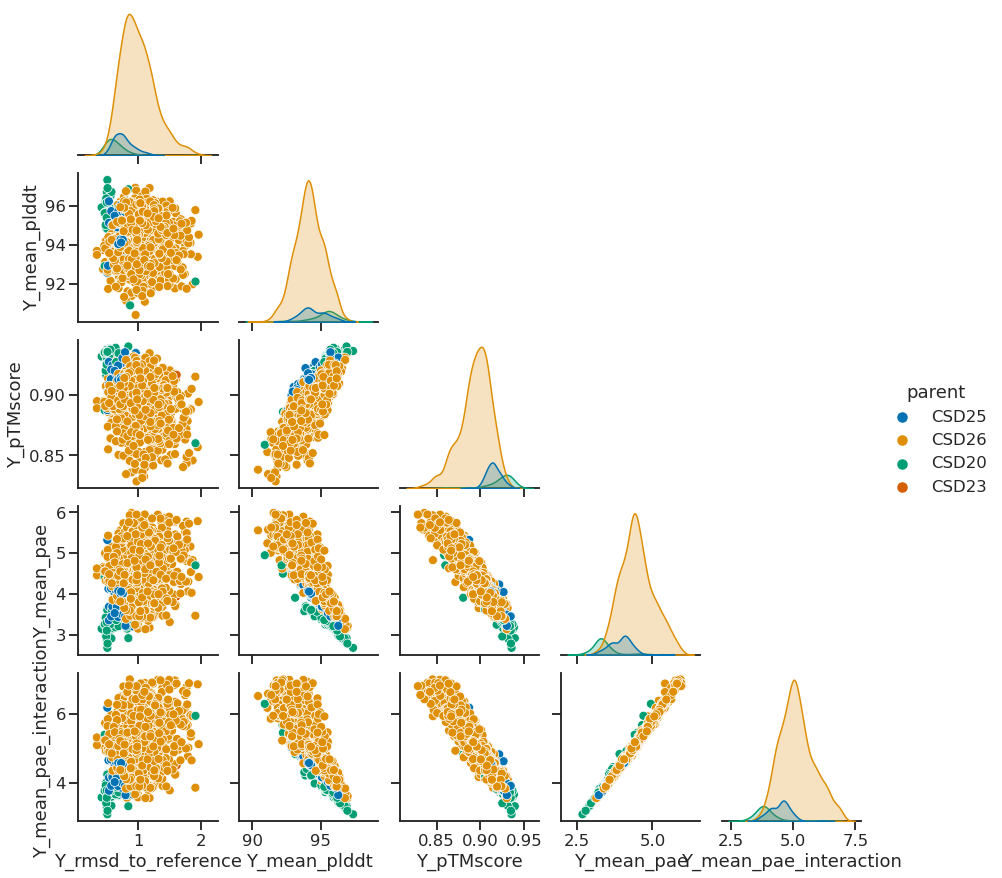

In [30]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

the_fig = pairplot_df(
    df=unique_df,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [31]:
import os
simulation_name = "03_fold_dimer_Y"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"

with open(os.path.join(output_path, "folded_paired_states.list"), "w") as f:
    for path in unique_df.index:
        print(path, file=f)

Go fold on perlmutter

## Filter the state X folds

### Collect scorefiles of the folded paired state Ys and concatenate

In [6]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "04_fold_dimer_X"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [7]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

100%|██████████| 14950/14950 [01:54<00:00, 130.14it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [10]:
import pandas as pd

if not os.path.exists(os.path.join(output_path, "scores_old.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores_old.csv"))

In [12]:
# mpnn scores were accidentally not included in the folding function
# get them from the original files

sbatch_fname = 'fix_scores'
simulation_name = '04_fold_dimer_X'

from glob import glob
from more_itertools import chunked

task_lines = []

for i, files in enumerate(chunked(sorted(glob(f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}/decoys/*/*.pdb.bz2")), 50)):
    task_lines.append(f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}/{sbatch_fname}.py {i:04d} {' '.join(files)}\n")

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}/{sbatch_fname}.tasks', 'w') as tasks_file:
    tasks_file.write(''.join(task_lines))

print(f'sbatch -a 1-$(cat {sbatch_fname}.tasks | wc -l) {sbatch_fname}.sh')

sbatch_script = \
f"""#!/usr/bin/env bash 
#SBATCH -J {sbatch_fname}
#SBATCH -e /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.err 
#SBATCH -o /home/broerman/projects/CSD/slurm_logs/{sbatch_fname}-%J.out 
#SBATCH -p short
#SBATCH -c 1
#SBATCH --mem=1G

JOB_ID=${{SLURM_JOB_ID%;*}}
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" /home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}/{sbatch_fname}.tasks) 
echo "${{CMD}}" | bash
"""

with open(f'/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}/{sbatch_fname}.sh', 'w') as sh_file:
    sh_file.write(sbatch_script)

sbatch -a 1-$(cat fix_scores.tasks | wc -l) fix_scores.sh


In [1]:
import pandas as pd
import os
simulation_name = "04_fold_dimer_X"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
scores_df_old = pd.read_csv(os.path.join(output_path, "scores_old.csv"), index_col="Unnamed: 0")

In [2]:
# add mpnn scores to scores_df
from glob import glob
mpnn_scores_df = pd.DataFrame()
partial_scores_dfs = []
for partial_scores_csv in glob(f'{simulation_name}/fixed_scores/*.csv'):
    partial_scores_df = pd.read_csv(partial_scores_csv, index_col="Unnamed: 0")
    partial_scores_dfs.append(partial_scores_df)
mpnn_scores_df = pd.concat(partial_scores_dfs)
scores_df = pd.concat([scores_df_old, mpnn_scores_df], axis=1)
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

In [1]:
import pandas as pd
import os
simulation_name = "04_fold_dimer_X"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(scores_df)

,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id
/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0010/04_fold_dimer_X_4bdf429e669144c682efd80823056d20.pdb.bz2,4.916285,NaN,4.876475,4.876475,94.897537,1,0.780461,A,3.0,4.051571,0,0.070080,monomer_ptm,4.387318,5.054173,5.031125,5.077221,3.686963,4.348881,3.025046,93.143654,2,0.880712,3.0,0.955449,0,0.615987,monomer_ptm,mpnn,0.0,80.618614,-4914.339292,1592.639814,-1638.709132,1499.217845,174.912193,9867.172299,3569.561496,-24.377968,-30.378471,-66.400799,-687.779550,-81.251036,4.916285,NaN,4.876475,4.876475,94.897537,1,119.668009,0.780461,-247.938543,3.855842,-368.550916,3.0,76.04174,4.051571,0,0.070080,2664.643872,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD26,2512,mpnn_seq_0005
/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0010/04_fold_dimer_X_19bafbaf80ea494fab1340a0ccc47d37.pdb.bz2,4.680041,NaN,4.590363,4.590363,92.690384,3,0.808294,B,3.0,1.427970,0,0.065648,monomer_ptm,4.263810,4.869418,5.046701,4.692135,3.556943,4.104381,3.009505,94.251289,1,0.903607,3.0,0.930583,0,0.164480,monomer_ptm,mpnn,0.0,4.944269,-4854.644324,1626.840284,-1644.266512,1507.676253,181.881645,6700.716865,3569.372447,-24.941409,-30.397169,-59.013557,-688.495025,-87.202167,4.680041,NaN,4.590363,4.590363,92.690384,3,165.971615,0.808294,-234.728062,2.347366,-334.005577,3.0,-88.79722,1.427970,0,0.065648,883.401072,monomer_ptm,5.361473e-08,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0007
/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0010/04_fold_dimer_X_30a7fdb58da44400963295308a20469f.pdb.bz2,5.334515,NaN,5.269916,5.269916,93.494682,1,0.764838,A,3.0,3.513410,0,0.358851,monomer_ptm,4.291048,4.884768,5.078591,4.690946,3.626572,4.414008,2.839136,94.684280,3,0.901336,3.0,1.570545,0,0.245267,monomer_ptm,mpnn,0.0,88.612389,-4974.721186,1540.987078,-1621.112990,1550.026445,175.620692,6710.770538,3543.318168,-19.614485,-28.468532,-61.332740,-689.363163,-95.182430,5.334515,NaN,5.269916,5.269916,93.494682,1,125.471315,0.764838,-250.690529,8.717934,-319.285920,3.0,112.35424,3.513410,0,0.358851,885.855420,monomer_ptm,8.065630e-08,mpnn,full,0.2,CSD26,4122,mpnn_seq_0003
/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0010/04_fold_dimer_X_5a20ac8ea59d4a4dbbe2154f395375fb.pdb.bz2,5.482634,NaN,5.388583,5.388583,91.419754,3,0.769912,A,3.0,0.776399,0,0.111268,monomer_ptm,4.406304,5.035194,5.147027,4.923362,3.670094,4.111199,3.228990,93.332428,2,0.898973,3.0,0.802361,0,0.133649,monomer_ptm,mpnn,0.0,5.114793,-4870.386554,1650.474906,-1645.506934,1479.854344,186.090231,6419.870692,3597.427976,-21.211235,-30.329880,-60.143516,-685.161114,-96.171413,5.482634,NaN,5.388583,5.388583,91.419754,3,110.077057,0.769912,-244.196285,4.474140,-368.279052,3.0,-103.88146,0.776399,0,0.111268,701.766840,monomer_ptm,0.000000e+00,mpnn,interface,0.2,CSD26,2423,mpnn_seq_0002
/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0010/04_fold_dimer_X_1b48c3206420472cad136185ac507eae.pdb.bz2,3.270248,NaN,3.149255,3.149255,95.676659,3,0.895631,A,3.0,1.397851,0,0.055783,monomer_ptm,5.322169,6.173054,6.291511,6.054597,4.356476,5.371846,3.341106,92.566971,1,0.887233,3.0,0.506425,0,0.275122,monomer_ptm,mpnn,0.0,4.034526,-4085.194656,1410.682926,-1215.698234,1213.964210,147.5219

### Setup for plotting

In [2]:
import seaborn as sns

sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [6]:
sample_A = scores_df[scores_df["X_protomer"] == "A"].sample(1000, random_state=0)
sample_B = scores_df[scores_df["X_protomer"] == "B"].sample(1000, random_state=0)
sample_df = pd.concat([sample_A, sample_B])

# sample_df = scores_df.sample(2000, random_state=0)

### Remove score terms we don't care about

In [5]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1000
['X_mean_pae', 'X_mean_pae_interaction', 'X_mean_pae_intra_chain', 'X_mean_pae_intra_chain_A', 'X_mean_plddt', 'X_model', 'X_pTMscore', 'X_protomer', 'X_recycles', 'X_rmsd_to_input', 'X_seed', 'X_tol', 'X_type', 'Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol', 'Y_type', 'designed_by', 'elapsed_time', 'mean_pae', 'mean_pae_interaction', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_plddt', 'model', 'pTMscore', 'recycles', 'rmsd_to_input', 'seed', 'tol', 'total_score', 'type', 'designed_by.1', 'mpnn_msd_design_area', 'mpnn_msd_temperature', 'parent', 'combo', 'mpnn_seq_id']


### Plot AF2 metrics

4it [00:00,  8.41it/s]


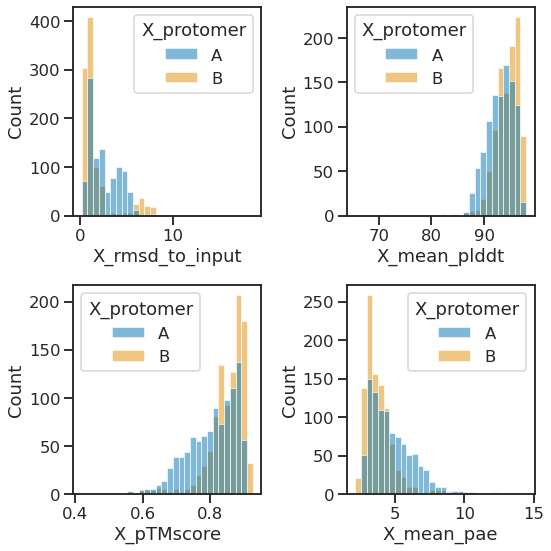

In [8]:
import matplotlib.pyplot as plt
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "X_rmsd_to_input",
    "X_mean_plddt",
    "X_pTMscore",
    "X_mean_pae"
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=30,
    hue="X_protomer",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1152x1152 with 0 Axes>

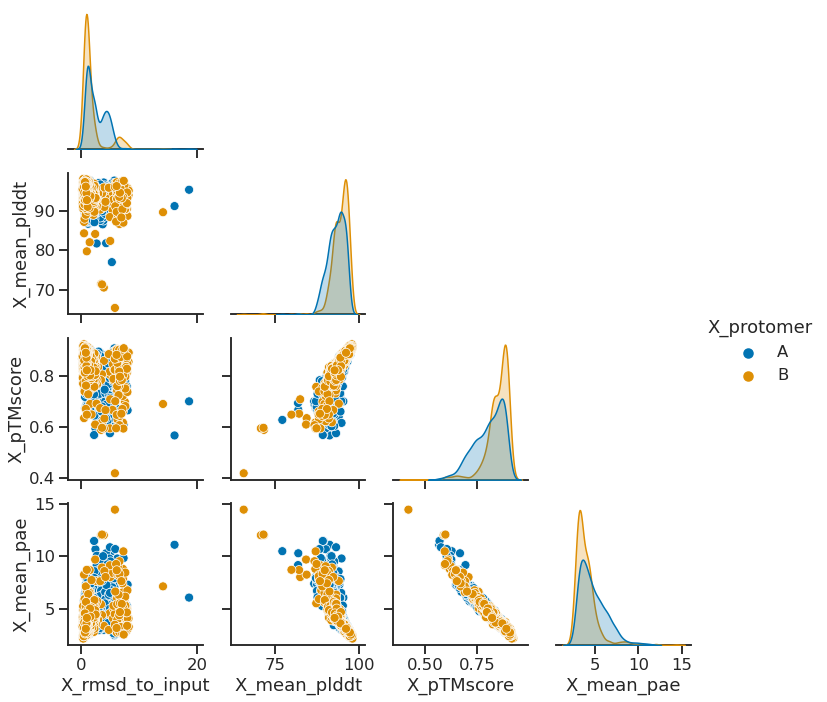

In [9]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="X_protomer",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

### Plot effects of MPNN selector areas on AF2 metrics

4it [00:00,  8.66it/s]


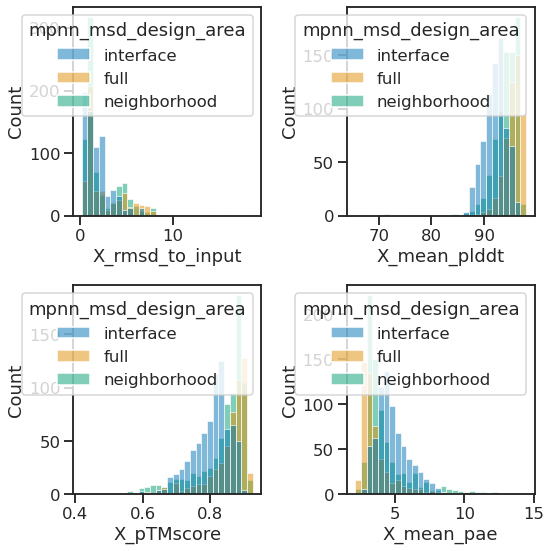

In [10]:
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=30,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

<Figure size 1152x1152 with 0 Axes>

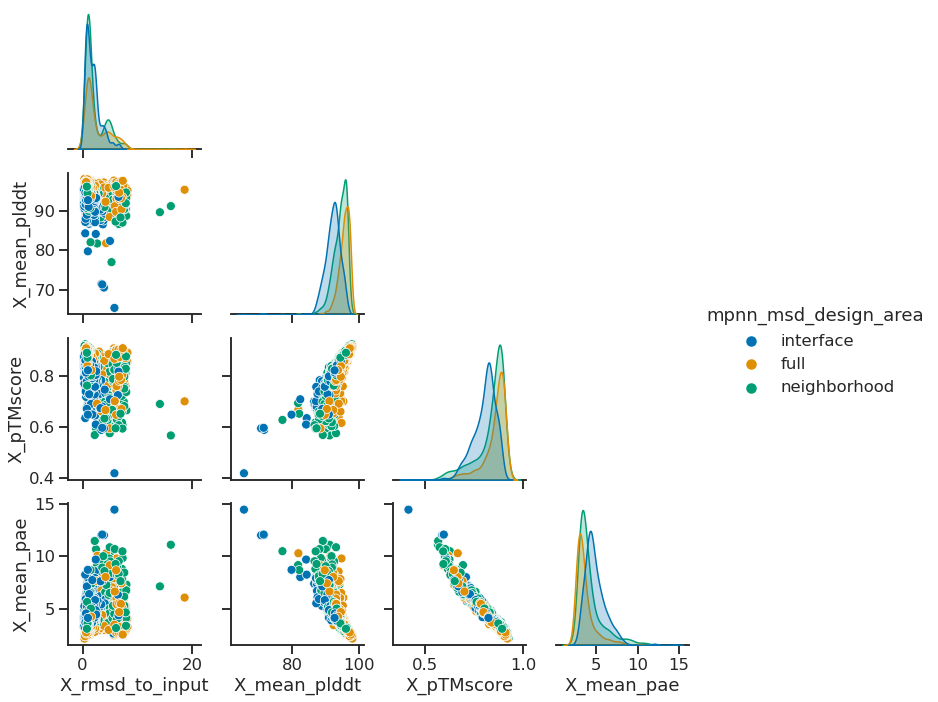

In [11]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="mpnn_msd_design_area",
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

### Filter the whole df

In [2]:
query = "X_mean_plddt > 93 and X_mean_pae < 4 and X_rmsd_to_input < 1.5"

filtered = scores_df.query(query)
print(len(filtered))

5828


In [91]:
from tqdm.auto import tqdm

unique_df = pd.read_csv("/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/03_fold_dimer_Y/scores_unique.csv")

# fix rare situations where annotating the mpnn sequence was imperfect
filtered.loc[200, "mpnn_seq_id"] = "mpnn_seq_0004"
filtered.loc[787, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[804, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[933, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[938, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[994, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2434, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2479, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2490, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2507, "mpnn_seq_id"] = "mpnn_seq_0006"
filtered.loc[2739, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2757, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[2829, "mpnn_seq_id"] = "mpnn_seq_0004"
filtered.loc[3007, "mpnn_seq_id"] = "mpnn_seq_0004"
filtered.loc[3108, "mpnn_seq_id"] = "mpnn_seq_0004"
filtered.loc[3237, "mpnn_seq_id"] = "mpnn_seq_0008"
filtered.loc[4362, "mpnn_seq_id"] = "mpnn_seq_0005"
filtered.loc[4457, "mpnn_seq_id"] = "mpnn_seq_0005"
filtered.loc[4460, "mpnn_seq_id"] = "mpnn_seq_0005"
filtered.loc[4574, "mpnn_seq_id"] = "mpnn_seq_0005"
filtered.loc[4628, "mpnn_seq_id"] = "mpnn_seq_0005"
filtered.loc[5061, "mpnn_seq_id"] = "mpnn_seq_0006"
filtered.loc[5238, "mpnn_seq_id"] = "mpnn_seq_0006"
filtered.loc[5268, "mpnn_seq_id"] = "mpnn_seq_0006"

for index, row in filtered.iterrows():
    unique_combo = row["parent"] + "_" + str(row["combo"]) + "_" + row["mpnn_msd_design_area"] + "_" + row["mpnn_seq_id"]
    filtered.loc[index, "unique_combo"] = unique_combo

for index in tqdm(filtered.index):
    try:
        filtered.loc[index, "num_Y_models"] = unique_df[unique_df["unique_combo"] == filtered.loc[index, "unique_combo"]]["num_Y_models"].values[0]
    except IndexError:
        print(index, filtered.loc[index, "unique_combo"])
        break

100%|██████████| 5828/5828 [00:05<00:00, 1088.84it/s]


In [84]:
unique_df[unique_df['unique_combo'].str.startswith('CSD26_2422_interface_mpnn_seq')]

,Unnamed: 0,Unnamed: 0.1,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,...,total_score,yhh_planarity,designed_by,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models
261,490,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.291656,4.895493,5.071577,4.719409,3.588261,4.041844,3.134678,94.130234,...,1224.709403,1.509357e-07,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0001,CSD26_2422_interface_mpnn_seq_0001,2.0
263,508,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.242327,4.829618,4.991479,4.667756,3.547938,4.010211,3.085666,94.366768,...,1714.334485,2.054505e-08,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0003,CSD26_2422_interface_mpnn_seq_0003,3.0
268,512,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,5.010552,5.842107,6.203902,5.480311,4.079226,5.129821,3.028631,93.292168,...,2375.066811,2.237436e-09,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0006,CSD26_2422_interface_mpnn_seq_0006,1.0
967,1938,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.263810,4.869418,5.046701,4.692135,3.556943,4.104381,3.009505,94.251289,...,883.401072,5.361473e-08,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0007,CSD26_2422_interface_mpnn_seq_0007,1.0
973,1949,/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys...,4.373785,4.998032,5.235733,4.760331,3.649601,4.255757,3.043445,94.113373,...,463.714147,1.457446e-08,mpnn,interface,0.2,CSD26,2422,mpnn_seq_0008,CSD26_2422_interface_mpnn_seq_0008,2.0


In [85]:
print(filtered.loc[5061, "Unnamed: 0"])
print(filtered.loc[5061, 'X_protomer'])

/pscratch/sd/b/broerman/04_fold_dimer_X/decoys/0001/04_fold_dimer_X_8bcfab6ad5fe41758f946afe9c7a9896.pdb.bz2
B


In [88]:
print(unique_df.loc[268, "Unnamed: 0.1"])

/pscratch/sd/b/broerman/03_fold_dimer_Y/decoys/0031/03_fold_dimer_Y_a2d0ec4c1f5e47ef9da4c4b77f95742b.pdb.bz2


In [92]:
filtered['num_Y_models'].value_counts()

1.0    3141
2.0    1314
3.0     968
4.0     307
5.0      87
6.0      11
Name: num_Y_models, dtype: int64

In [93]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(filtered)

,Unnamed: 0,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models
0,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.270248,NaN,3.149255,3.149255,95.676659,3,0.895631,A,3.0,1.397851,0,0.055783,monomer_ptm,5.322169,6.173054,6.291511,6.054597,4.356476,5.371846,3.341106,92.566971,1,0.887233,3.0,0.506425,0,0.275122,monomer_ptm,mpnn,0.0,4.034526,-4085.194656,1410.682926,-1215.698234,1213.964210,147.521906,5899.451866,2991.089265,-35.005986,-11.229438,-38.785041,-529.201037,-68.575906,3.270248,NaN,3.149255,3.149255,95.676659,3,146.386533,0.895631,-193.750808,15.343034,-221.284358,3.0,-132.83388,1.397851,0,0.055783,1122.238348,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD25,5511,mpnn_seq_0004,CSD25_5511_neighborhood_mpnn_seq_0004,1.0
1,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.173715,NaN,3.064435,3.064435,96.037125,3,0.890436,B,3.0,0.585163,0,0.080203,monomer_ptm,5.385913,6.217568,6.199572,6.235566,4.469491,5.079840,3.859143,93.054062,1,0.864823,3.0,1.282577,0,0.198585,monomer_ptm,mpnn,0.0,4.858265,-4936.417502,1685.984175,-1654.798319,1496.873835,178.595923,7087.898298,3612.445255,-22.302443,-31.229442,-52.362720,-691.616367,-86.844265,3.173715,NaN,3.064435,3.064435,96.037125,3,136.644872,0.890436,-247.828152,2.627113,-344.850445,3.0,-55.76178,0.585163,0,0.080203,1099.787944,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD26,4231,mpnn_seq_0006,CSD26_4231_neighborhood_mpnn_seq_0006,1.0
2,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.767358,NaN,2.730190,2.730190,96.795326,5,0.894169,A,3.0,1.374462,0,0.097000,monomer_ptm,3.790805,4.335969,4.332395,4.339543,3.181605,3.367572,2.995638,95.501175,1,0.898225,3.0,1.392286,0,0.139827,monomer_ptm,mpnn,0.0,4.977319,-4968.143901,1640.222735,-1682.283102,1737.059564,174.360306,10297.899142,3558.139181,-26.587093,-29.367330,-74.736326,-689.537948,-63.684076,2.767358,NaN,2.730190,2.730190,96.795326,5,168.001974,0.894169,-227.379287,199.608886,-268.405996,3.0,50.02106,1.374462,0,0.097000,3128.368140,monomer_ptm,2.582536e-07,mpnn,full,0.2,CSD26,2322,mpnn_seq_0002,CSD26_2322_full_mpnn_seq_0002,2.0
3,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.769325,NaN,2.735491,2.735491,97.158363,1,0.897022,A,3.0,1.400788,0,0.087118,monomer_ptm,3.766624,4.326449,4.518693,4.134206,3.128217,3.675889,2.580546,95.309807,2,0.914935,3.0,1.223245,0,0.535752,monomer_ptm,mpnn,0.0,82.226303,-4971.624155,1635.707769,-1632.503075,1547.500691,180.390511,7520.437235,3652.946873,-26.243678,-29.290416,-68.259949,-688.141671,-89.603373,2.769325,NaN,2.735491,2.735491,97.158363,1,125.360448,0.897022,-256.769448,4.306242,-391.932256,3.0,0.02556,1.400788,0,0.087118,1341.765847,monomer_ptm,6.789551e-07,mpnn,full,0.2,CSD26,4522,mpnn_seq_0002,CSD26_4522_full_mpnn_seq_0002,2.0
4,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.652936,NaN,3.622991,3.622991,95.327858,4,0.858326,A,3.0,1.385562,0,0.076014,monomer_ptm,3.790805,4.335969,4.332395,4.339543,3.181605,3.367572,2.995638,95.501175,1,0.898225,3.0,1.392286,0,0.139827,monomer_ptm,mpnn,0.0,5.044285,-4968.143901,1640.222735,-1682.283102,1737.059564,174.360306,10297.899142,3558.139181,-26.587093,-29.367330,-74.736326,-689.537948,-63.684076,3.

In [96]:
if not os.path.exists(os.path.join(output_path, "scores_filtered.csv")):
    filtered.to_csv(os.path.join(output_path, "scores_filtered.csv"))

In [98]:
simulation_name = "04_fold_dimer_X"
output_path = f"/home/broerman/crispy_shifty/projects/crispy_shifty_dimers/round_2/mpnn_upweight_int/{simulation_name}"
filtered = pd.read_csv(os.path.join(output_path, "scores_filtered.csv"))
filtered

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,...,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models
0,0,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.270248,NaN,3.149255,3.149255,95.676659,3,0.895631,A,...,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD25,5511,mpnn_seq_0004,CSD25_5511_neighborhood_mpnn_seq_0004,1.0
1,1,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.173715,NaN,3.064435,3.064435,96.037125,3,0.890436,B,...,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD26,4231,mpnn_seq_0006,CSD26_4231_neighborhood_mpnn_seq_0006,1.0
2,2,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.767358,NaN,2.730190,2.730190,96.795326,5,0.894169,A,...,monomer_ptm,2.582536e-07,mpnn,full,0.2,CSD26,2322,mpnn_seq_0002,CSD26_2322_full_mpnn_seq_0002,2.0
3,3,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.769325,NaN,2.735491,2.735491,97.158363,1,0.897022,A,...,monomer_ptm,6.789551e-07,mpnn,full,0.2,CSD26,4522,mpnn_seq_0002,CSD26_4522_full_mpnn_seq_0002,2.0
4,4,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.652936,NaN,3.622991,3.622991,95.327858,4,0.858326,A,...,monomer_ptm,2.582536e-07,mpnn,full,0.2,CSD26,2322,mpnn_seq_0002,CSD26_2322_full_mpnn_seq_0002,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,5823,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.677669,NaN,2.603124,2.603124,97.323463,1,0.900963,B,...,monomer_ptm,1.290740e-07,mpnn,full,0.2,CSD26,5411,mpnn_seq_0002,CSD26_5411_full_mpnn_seq_0002,1.0
5824,5824,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.359416,NaN,3.260782,3.260782,95.573639,1,0.868120,A,...,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD26,1432,mpnn_seq_0005,CSD26_1432_neighborhood_mpnn_seq_0005,1.0
5825,5825,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.289970,NaN,3.192464,3.192464,95.414963,1,0.875800,B,...,monomer_ptm,0.000000e+00,mpnn,neighborhood,0.2,CSD26,3331,mpnn_seq_0008,CSD26_3331_neighborhood_mpnn_seq_0008,1.0
5826,5826,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.859491,NaN,3.767377,3.767377,93.731758,2,0.853408,B,...,monomer_ptm,0.000000e+00,mpnn,interface,0.2,CSD26,2421,mpnn_seq_0003,CSD26_2421_interface_mpnn_seq_0003,2.0


In [99]:
print(filtered['parent'].value_counts())

CSD26    4864
CSD25     622
CSD20     333
CSD23       9
Name: parent, dtype: int64


In [100]:
filtered_full = filtered.query("mpnn_msd_design_area == 'full'")
filtered_nbhd = filtered.query("mpnn_msd_design_area == 'neighborhood'")
print(len(filtered_full))
print(len(filtered_nbhd))

cols = [
    "X_rmsd_to_input",
    "X_mean_plddt",
    "X_pTMscore",
    "X_mean_pae",
]

1948
2766


<Figure size 1152x1152 with 0 Axes>

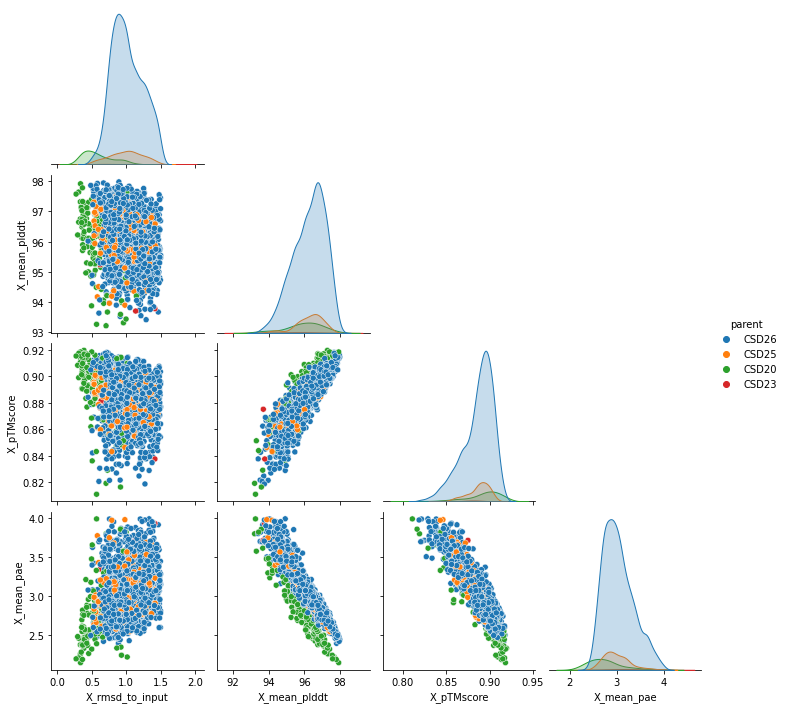

In [101]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

the_fig = pairplot_df(
    df=filtered_full,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

<Figure size 1152x1152 with 0 Axes>

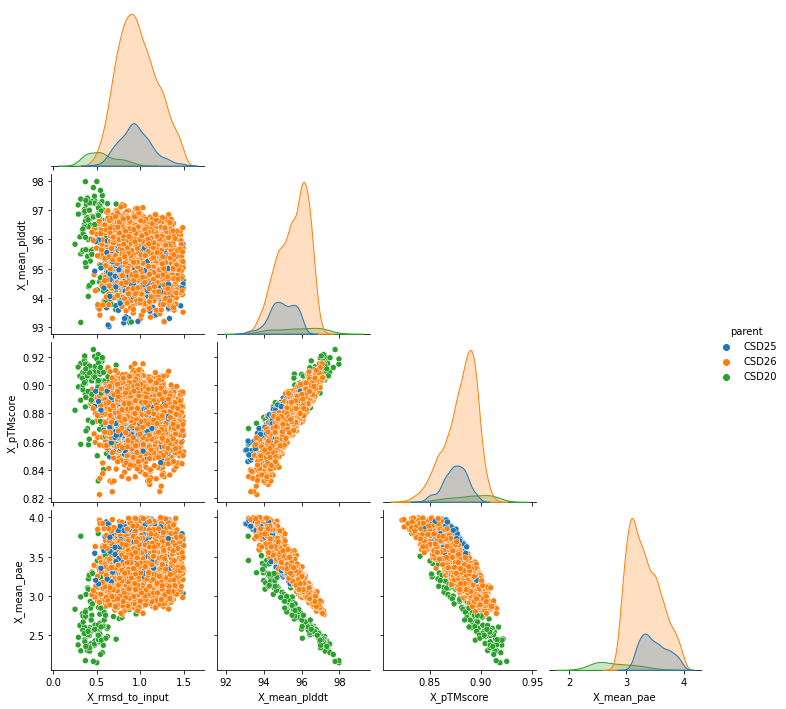

In [102]:
the_fig = pairplot_df(
    df=filtered_nbhd,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [103]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(filtered_full[filtered_full["parent"] == "CSD23"])

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models
2443,2443,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.758693,NaN,2.695444,2.695444,97.073982,5,0.890603,A,3.0,0.651867,0,0.072995,monomer_ptm,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,3.0,1.616566,0,0.174637,monomer_ptm,mpnn,0.0,4.907011,-4866.002182,1374.044374,-1524.972157,1547.202132,152.88467,5498.157248,3228.431384,-26.026281,-17.705747,-48.996928,-661.459491,-100.442666,2.758693,NaN,2.695444,2.695444,97.073982,5,144.939647,0.890603,-243.929854,4.429773,-311.782541,3.0,249.94334,0.651867,0,0.072995,156.06052,monomer_ptm,0.0,mpnn,full,0.2,CSD23,4211,mpnn_seq_0006,CSD23_4211_full_mpnn_seq_0006,1.0
2455,2455,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.712445,NaN,3.621688,3.621688,93.699059,4,0.875014,B,3.0,1.135675,0,0.088903,monomer_ptm,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,3.0,1.616566,0,0.174637,monomer_ptm,mpnn,0.0,4.942842,-4866.002182,1374.044374,-1524.972157,1547.202132,152.88467,5498.157248,3228.431384,-26.026281,-17.705747,-48.996928,-661.459491,-100.442666,3.712445,NaN,3.621688,3.621688,93.699059,4,144.939647,0.875014,-243.929854,4.429773,-311.782541,3.0,249.94334,1.135675,0,0.088903,156.06052,monomer_ptm,0.0,mpnn,full,0.2,CSD23,4211,mpnn_seq_0006,CSD23_4211_full_mpnn_seq_0006,1.0
2488,2488,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.928672,NaN,3.825579,3.825579,93.778709,1,0.837469,B,3.0,1.415875,0,0.161598,monomer_ptm,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,3.0,1.616566,0,0.174637,monomer_ptm,mpnn,0.0,74.115219,-4866.002182,1374.044374,-1524.972157,1547.202132,152.88467,5498.157248,3228.431384,-26.026281,-17.705747,-48.996928,-661.459491,-100.442666,3.928672,NaN,3.825579,3.825579,93.778709,1,144.939647,0.837469,-243.929854,4.429773,-311.782541,3.0,249.94334,1.415875,0,0.161598,156.06052,monomer_ptm,0.0,mpnn,full,0.2,CSD23,4211,mpnn_seq_0006,CSD23_4211_full_mpnn_seq_0006,1.0
2523,2523,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.395579,NaN,3.302929,3.302929,95.094765,3,0.881471,B,3.0,0.993767,0,0.115878,monomer_ptm,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,3.0,1.616566,0,0.174637,monomer_ptm,mpnn,0.0,4.929444,-4866.002182,1374.044374,-1524.972157,1547.202132,152.88467,5498.157248,3228.431384,-26.026281,-17.705747,-48.996928,-661.459491,-100.442666,3.395579,NaN,3.302929,3.302929,95.094765,3,144.939647,0.881471,-243.929854,4.429773,-311.782541,3.0,249.94334,0.993767,0,0.115878,156.06052,monomer_ptm,0.0,mpnn,full,0.2,CSD23,4211,mpnn_seq_0006,CSD23_4211_full_mpnn_seq_0006,1.0
2636,2636,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.013680,NaN,2.936402,2.936402,96.122856,2,0.880261,A,3.0,0.683881,0,0.051919,monomer_ptm,3.938776,4.510931,4.384651,4.637212,3.257691,3.186833,3.328549,94.692886,1,0.916169,3.0,1.616566,0,0.174637,monomer_ptm,mpnn,0.0,5.014628,-4866.002182,1374.044374,-1524.972157,1547.202132,152.88467,5498.157248,3228.431384,-26.026281,-17.705747,-48.996928,-661.459491,-100.442666,3.013680,NaN,2.936402,2.9364

In [123]:
query = "Y_mean_plddt > 94.5 and X_mean_plddt > 94.5 and Y_mean_pae < 4 and Y_rmsd_to_reference < 1.7 and Y_pTMscore > 0.91"
filtered_2_df = filtered.query(query)
print(len(filtered_2_df))
filtered_2_df['parent'].value_counts()

1202


CSD26    781
CSD25    216
CSD20    198
CSD23      7
Name: parent, dtype: int64

In [124]:
# filter based on whether both X protomers passed the filters for a given design

unique_combos = set()
for index, row in filtered_2_df.iterrows():
    unique_combos.add(row['unique_combo'])

combos_to_keep = set()
for unique_combo in unique_combos:
    if filtered_2_df[filtered_2_df['unique_combo'] == unique_combo]['X_protomer'].nunique() == 2:
        combos_to_keep.add(unique_combo)

complete_df = pd.DataFrame(columns=filtered_2_df.columns)
for combo in combos_to_keep:
    combo_A_df = filtered_2_df.query(f"unique_combo == '{combo}' and X_protomer == 'A'")
    combo_B_df = filtered_2_df.query(f"unique_combo == '{combo}' and X_protomer == 'B'")
    best_index_A = combo_A_df['X_mean_plddt'].idxmax()
    complete_df.loc[best_index_A] = combo_A_df.loc[best_index_A]
    complete_df.loc[best_index_A, "num_XA_models"] = len(combo_A_df)
    complete_df.loc[best_index_A, "num_XB_models"] = len(combo_B_df)
    best_index_B = combo_B_df['X_mean_plddt'].idxmax()
    complete_df.loc[best_index_B] = combo_B_df.loc[best_index_B]
    complete_df.loc[best_index_B, "num_XA_models"] = len(combo_A_df)
    complete_df.loc[best_index_B, "num_XB_models"] = len(combo_B_df)

with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(complete_df)

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models,num_XA_models,num_XB_models
4865,4865,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.716633,NaN,2.676596,2.676596,97.387085,1,0.896337,A,3.0,1.484026,0,0.137563,monomer_ptm,3.696890,4.242746,4.324323,4.161170,3.111761,3.573228,2.650295,95.885986,2,0.917048,3.0,1.592813,0,1.872725,monomer_ptm,mpnn,0.0,84.393166,-4878.196927,1536.169049,-1641.411298,1487.105978,169.526453,11031.716563,3532.784013,-28.361647,-31.779735,-66.389019,-694.639293,-88.770941,2.716633,NaN,2.676596,2.676596,97.387085,1,114.071638,0.896337,-248.263803,2.183135,-339.511302,3.0,110.08254,1.484026,0,0.137563,3279.661326,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD26,2211,mpnn_seq_0001,CSD26_2211_full_mpnn_seq_0001,2.0,4.0,1.0
4696,4696,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.033287,NaN,2.988703,2.988703,96.169670,4,0.888288,B,3.0,0.980586,0,0.059201,monomer_ptm,3.696890,4.242746,4.324323,4.161170,3.111761,3.573228,2.650295,95.885986,2,0.917048,3.0,1.592813,0,1.872725,monomer_ptm,mpnn,0.0,4.991390,-4878.196927,1536.169049,-1641.411298,1487.105978,169.526453,11031.716563,3532.784013,-28.361647,-31.779735,-66.389019,-694.639293,-88.770941,3.033287,NaN,2.988703,2.988703,96.169670,4,114.071638,0.888288,-248.263803,2.183135,-339.511302,3.0,110.08254,0.980586,0,0.059201,3279.661326,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD26,2211,mpnn_seq_0001,CSD26_2211_full_mpnn_seq_0001,2.0,4.0,1.0
3279,3279,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.818815,NaN,2.742847,2.742847,95.634003,5,0.882699,A,3.0,1.202116,0,0.096957,monomer_ptm,2.905629,3.342816,3.409352,3.276280,2.415629,2.477396,2.353863,96.724335,1,0.931400,3.0,0.572136,0,0.232217,monomer_ptm,mpnn,0.0,3.869632,-4006.231681,1110.235868,-1204.727471,1289.445934,121.675265,5321.862738,2555.234043,-24.792994,-10.552242,-32.883287,-518.441297,-90.582814,2.818815,NaN,2.742847,2.742847,95.634003,5,115.667381,0.882699,-209.016897,0.000000,-195.013176,3.0,243.25032,1.202116,0,0.096957,575.685571,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,5511,mpnn_seq_0007,CSD20_5511_full_mpnn_seq_0007,1.0,2.0,4.0
3415,3415,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.184384,NaN,2.121341,2.121341,97.780411,5,0.913510,B,3.0,0.362545,0,0.053177,monomer_ptm,2.905629,3.342816,3.409352,3.276280,2.415629,2.477396,2.353863,96.724335,1,0.931400,3.0,0.572136,0,0.232217,monomer_ptm,mpnn,0.0,3.800934,-4006.231681,1110.235868,-1204.727471,1289.445934,121.675265,5321.862738,2555.234043,-24.792994,-10.552242,-32.883287,-518.441297,-90.582814,2.184384,NaN,2.121341,2.121341,97.780411,5,115.667381,0.913510,-209.016897,0.000000,-195.013176,3.0,243.25032,0.362545,0,0.053177,575.685571,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,5511,mpnn_seq_0007,CSD20_5511_full_mpnn_seq_0007,1.0,2.0,4.0
3517,3517,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.975846,NaN,2.865073,2.865073,96.061172,5,0.884127,A,3.0,0.976315,0,0.064511,monomer_ptm,3.200999,3.664736,3.859633,3.469840,2.635705,3.038450,2.232959,96.023232,5,0.929892,3.0,0.915629,0,0.250685,monomer_ptm,mpnn,0.0,4.112015,-4009.997384,1116.254148,-1235.948278,1214.799226,114.569271,4199

In [125]:
complete_df.to_csv(os.path.join(output_path, "complete_filtered_df.csv"))

In [129]:
cols = [
    "X_rmsd_to_input",
    "X_mean_plddt",
    "X_pTMscore",
    "X_mean_pae",
    "Y_rmsd_to_reference",
    "Y_mean_plddt",
    "Y_pTMscore",
    "Y_mean_pae",
    "num_XA_models",
    "num_XB_models",
    "num_Y_models",
    "Y_mean_pae_interaction",
]

12it [00:00, 15.05it/s]


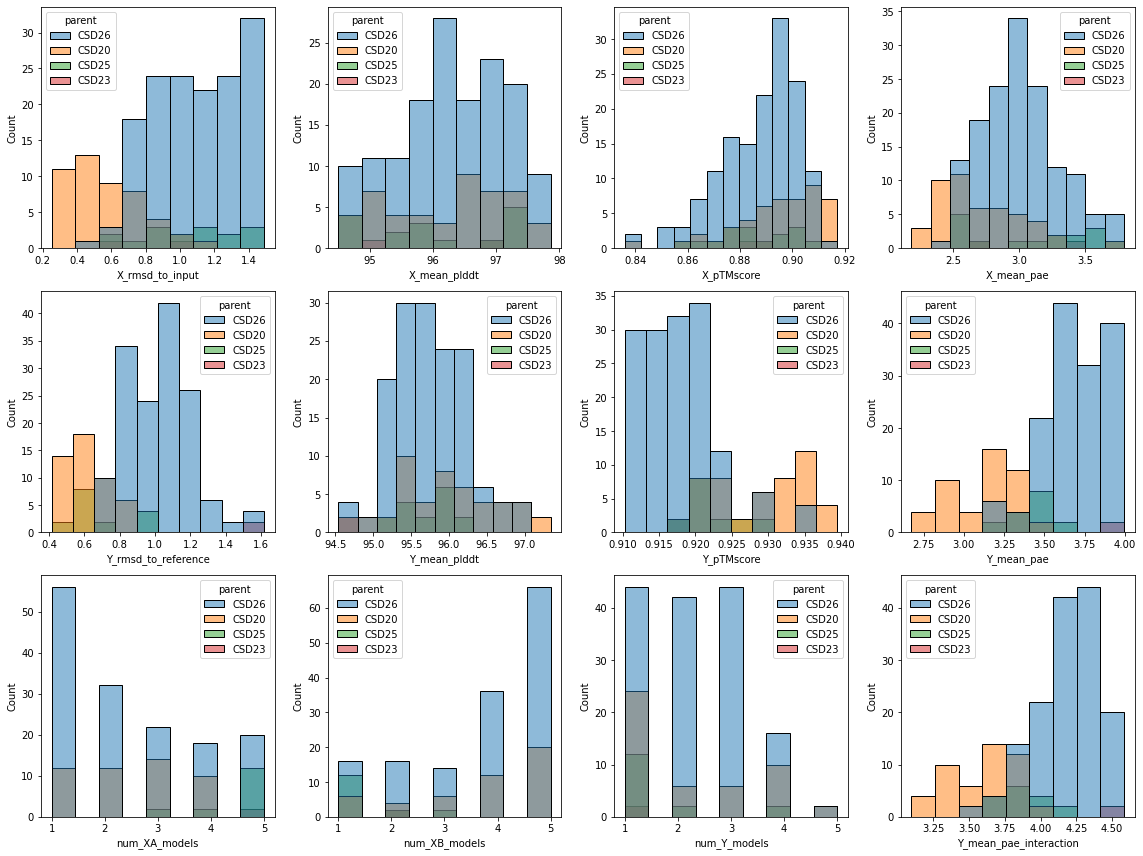

In [127]:
import sys
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

the_fig = histplot_df(
    df=complete_df,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [128]:
complete_full = complete_df.query("mpnn_msd_design_area == 'full'")
complete_nbhd = complete_df.query("mpnn_msd_design_area == 'neighborhood'")
print(len(complete_full))
print(len(complete_nbhd))

142
72


12it [00:01, 11.81it/s]


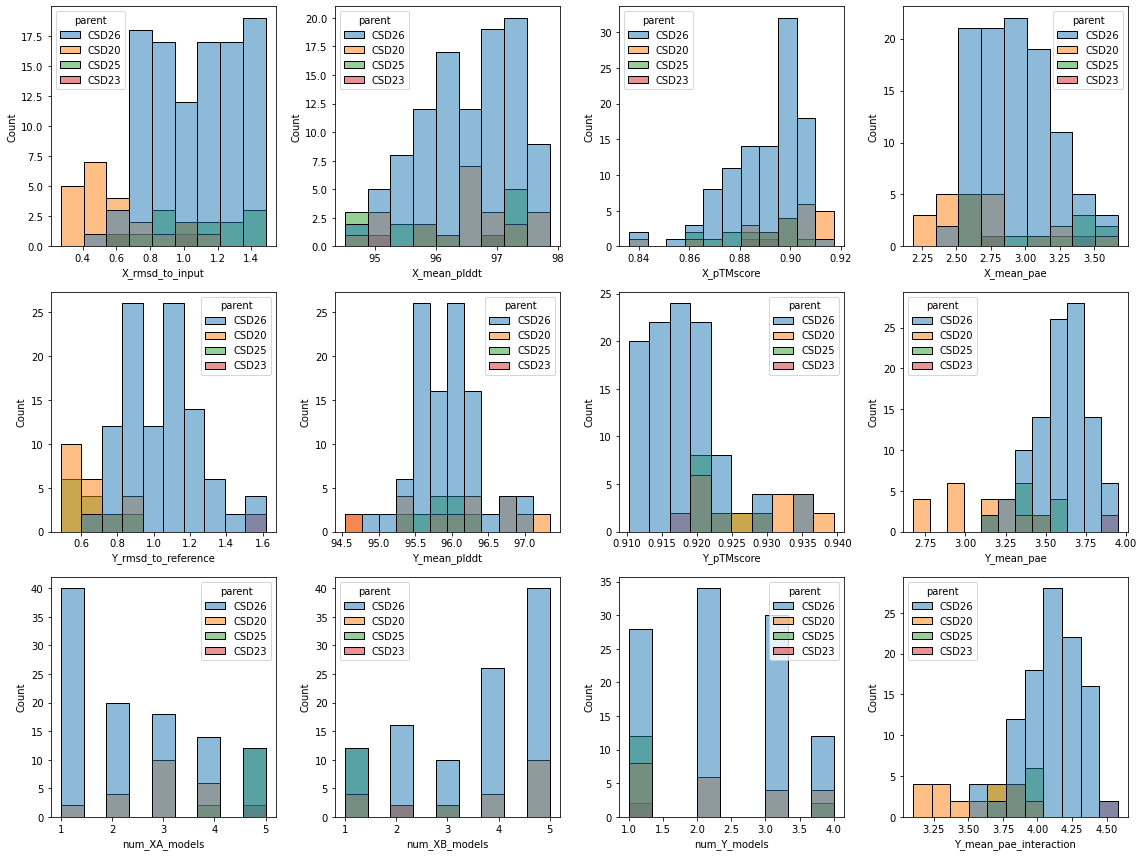

In [130]:
the_fig = histplot_df(
    df=complete_full,
    cols=cols,
    hue="parent"
)
# plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

12it [00:00, 14.41it/s]


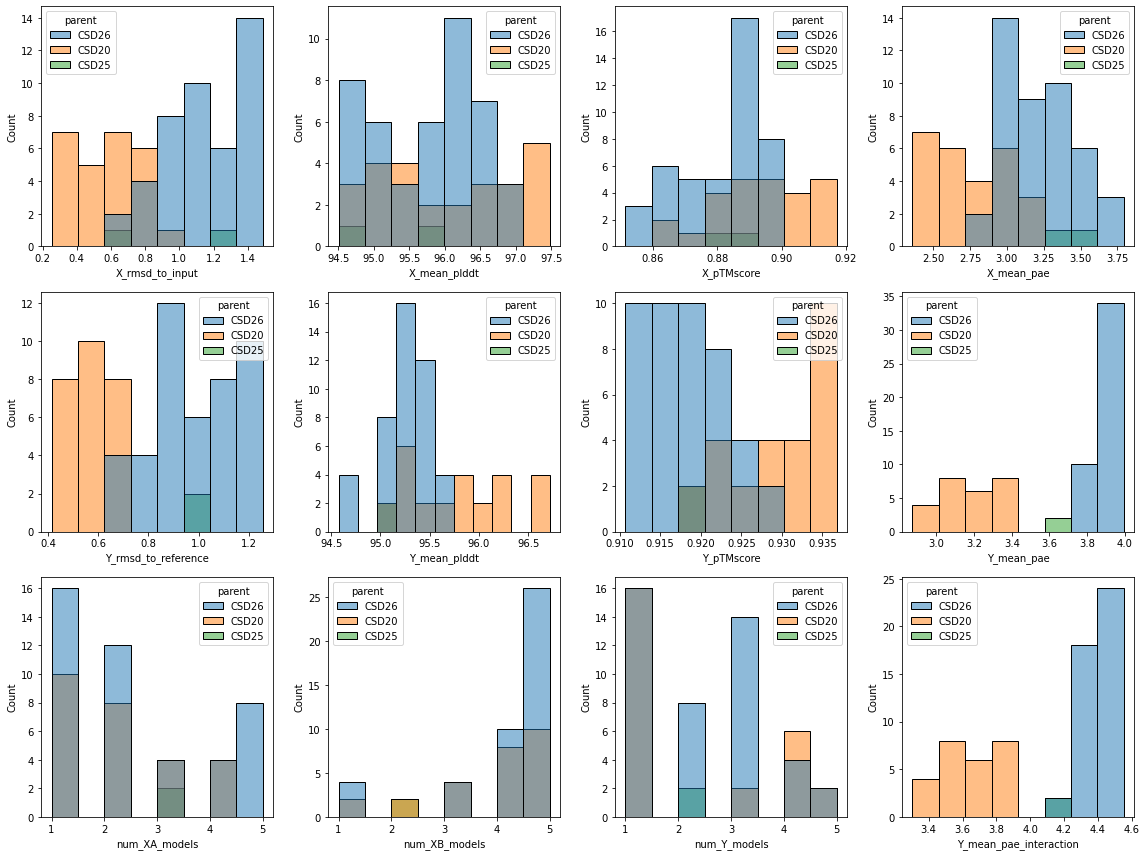

In [131]:
the_fig = histplot_df(
    df=complete_nbhd,
    cols=cols,
    hue="parent"
)

In [165]:
# lastly, filter on the number of models that find the correct structure with these (very stringent!) filtering metrics
# do this per parent and design area

# let's order one neighborhood redesign (best Y plddt) and several full redesigns for each parent (selected by sequence diversity and/or num_Y_models)

import os, shutil
import pyrosetta.distributed.cluster as cluster

def copy_designs(df, combo, out_path):
    combo_df = df[df['unique_combo'] == combo]
    for index, row in combo_df.iterrows():
        digs_fname_X = row['Unnamed: 0.1'][24:]
        shutil.copy(digs_fname_X, out_path + combo + '_' + row['X_protomer'] + '.pdb.bz2')
    digs_fname_Y = cluster.get_scores_dict(digs_fname_X)["instance"]["tasks"]["pdb_path"].split('____')[0][24:]
    shutil.copy(digs_fname_Y, out_path + combo + '_AB.pdb.bz2')

In [153]:
all_singles_to_copy = []

# CSD20 nbhd
des_set = complete_nbhd.loc[complete_nbhd[complete_nbhd['parent'] == 'CSD20']['Y_mean_plddt'].idxmax()]['unique_combo']
print('CSD20 nbhd', des_set)
all_singles_to_copy.append(des_set)

# CSD23 full
des_set = complete_full[complete_full['parent'] == 'CSD23']['unique_combo'].values[0]
print('CSD23 full', des_set)
all_singles_to_copy.append(des_set)

# CSD25 nbhd
des_set = complete_nbhd[complete_nbhd['parent'] == 'CSD25']['unique_combo'].values[0]
print('CSD25 nbhd', des_set)
all_singles_to_copy.append(des_set)

# CSD26 nbhd
des_set = complete_nbhd.loc[complete_nbhd[complete_nbhd['parent'] == 'CSD26']['Y_mean_plddt'].idxmax()]['unique_combo']
print('CSD26 nbhd', des_set)
all_singles_to_copy.append(des_set)

CSD20 nbhd CSD20_4511_neighborhood_mpnn_seq_0004
CSD23 full CSD23_4211_full_mpnn_seq_0006
CSD25 nbhd CSD25_3411_neighborhood_mpnn_seq_0008
CSD26 nbhd CSD26_2331_neighborhood_mpnn_seq_0003


In [156]:
for combo in all_singles_to_copy:
    copy_designs(complete_df, combo, '05_selected/selected_designs/')

In [190]:
CSD26_complete_full = complete_full.query("((num_Y_models >= 3 and num_XA_models >= 3 and num_XB_models >= 3) or (num_XA_models >= 5 and num_XB_models >= 5)) and parent == 'CSD26'")
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(CSD26_complete_full)

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models,num_XA_models,num_XB_models
2019,2019,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.774233,NaN,2.724826,2.724826,96.907303,5,0.902497,A,3.0,1.145943,0,0.052616,monomer_ptm,3.458345,3.922843,4.033488,3.812199,2.926708,3.169932,2.683485,96.242111,3,0.923007,3.0,1.185933,0,0.126831,monomer_ptm,mpnn,0.0,5.037093,-4900.521663,1556.189963,-1625.446994,1505.027313,167.274234,4693.218363,3527.230741,-22.086651,-28.824642,-58.723082,-682.533807,-95.554403,2.774233,NaN,2.724826,2.724826,96.907303,5,138.181597,0.902497,-226.641618,453.505641,-299.675898,3.0,119.35808,1.145943,0,0.052616,429.615589,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD26,5323,mpnn_seq_0004,CSD26_5323_full_mpnn_seq_0004,3.0,3.0,4.0
2173,2173,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.114554,NaN,3.046016,3.046016,95.670990,1,0.863277,B,3.0,0.914601,0,0.293219,monomer_ptm,3.458345,3.922843,4.033488,3.812199,2.926708,3.169932,2.683485,96.242111,3,0.923007,3.0,1.185933,0,0.126831,monomer_ptm,mpnn,0.0,77.791939,-4900.521663,1556.189963,-1625.446994,1505.027313,167.274234,4693.218363,3527.230741,-22.086651,-28.824642,-58.723082,-682.533807,-95.554403,3.114554,NaN,3.046016,3.046016,95.670990,1,138.181597,0.863277,-226.641618,453.505641,-299.675898,3.0,119.35808,0.914601,0,0.293219,429.615589,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD26,5323,mpnn_seq_0004,CSD26_5323_full_mpnn_seq_0004,3.0,3.0,4.0
3714,3714,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.804097,NaN,2.771534,2.771534,97.251213,3,0.907778,A,3.0,0.674334,0,0.077026,monomer_ptm,3.685397,4.219335,4.375165,4.063504,3.085084,3.536665,2.633504,95.847427,2,0.916291,3.0,1.335880,0,0.123860,monomer_ptm,mpnn,0.0,5.086941,-4959.472950,1712.713167,-1626.182331,1542.867285,173.791396,11063.855501,3662.240821,-26.221993,-27.741248,-61.220341,-694.916568,-88.353642,2.804097,NaN,2.771534,2.771534,97.251213,3,114.784064,0.907778,-249.131017,3.984471,-343.539058,3.0,51.36388,0.674334,0,0.077026,3441.844131,monomer_ptm,7.049308e-08,mpnn,full,0.2,CSD26,4421,mpnn_seq_0001,CSD26_4421_full_mpnn_seq_0001,3.0,3.0,3.0
3803,3803,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.827323,NaN,2.745784,2.745784,96.999535,5,0.898310,B,3.0,0.948445,0,0.052953,monomer_ptm,3.685397,4.219335,4.375165,4.063504,3.085084,3.536665,2.633504,95.847427,2,0.916291,3.0,1.335880,0,0.123860,monomer_ptm,mpnn,0.0,4.977415,-4959.472950,1712.713167,-1626.182331,1542.867285,173.791396,11063.855501,3662.240821,-26.221993,-27.741248,-61.220341,-694.916568,-88.353642,2.827323,NaN,2.745784,2.745784,96.999535,5,114.784064,0.898310,-249.131017,3.984471,-343.539058,3.0,51.36388,0.948445,0,0.052953,3441.844131,monomer_ptm,7.049308e-08,mpnn,full,0.2,CSD26,4421,mpnn_seq_0001,CSD26_4421_full_mpnn_seq_0001,3.0,3.0,3.0
4879,4879,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.873517,NaN,2.830099,2.830099,96.741501,3,0.903692,A,3.0,1.271435,0,0.059485,monomer_ptm,3.245711,3.705724,3.801748,3.609700,2.763814,2.992988,2.534640,96.789978,3,0.929657,3.0,0.970298,0,0.088892,monomer_ptm,mpnn,0.0,4.989969,-4936.639408,1566.507798,-1671.329760,1515.405692,170.495032,58

12it [00:00, 21.87it/s]


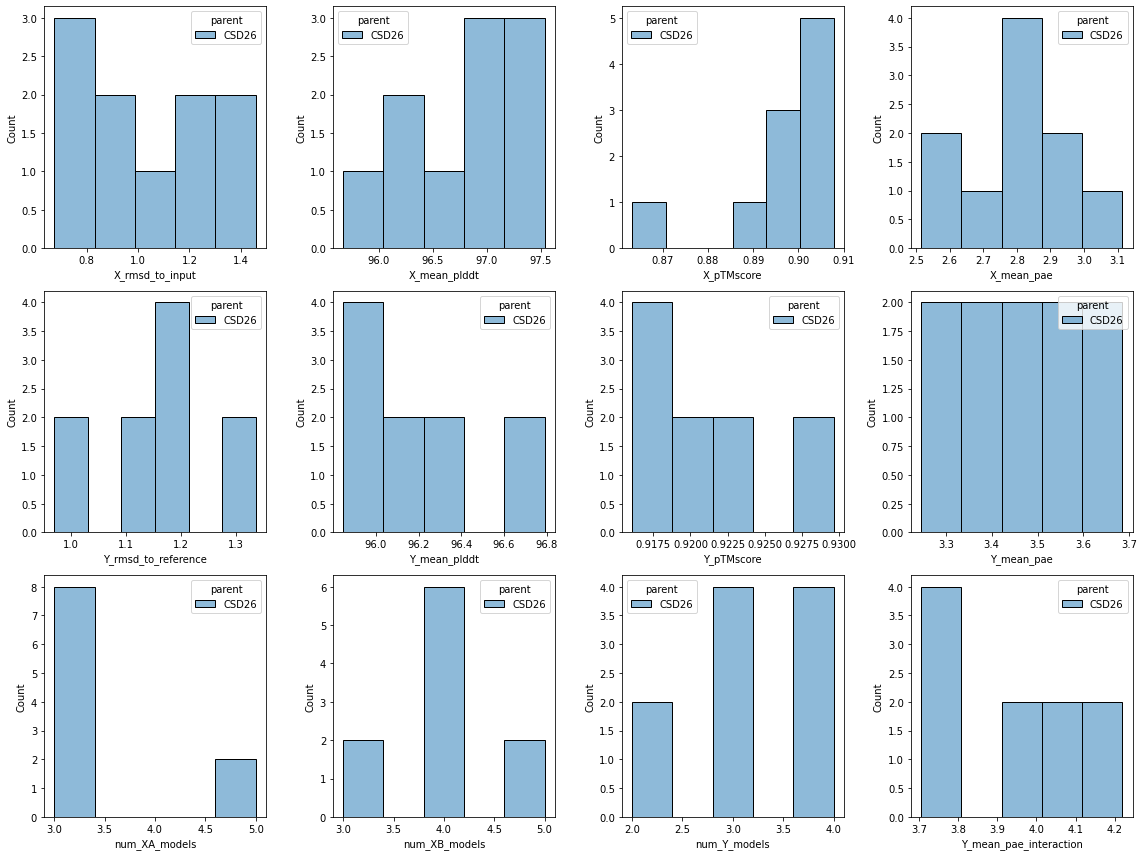

In [191]:
the_fig = histplot_df(
    df=CSD26_complete_full,
    cols=cols,
    hue="parent"
)

In [192]:
for combo in CSD26_complete_full['unique_combo'].values:
    copy_designs(CSD26_complete_full, combo, '05_selected/manual_filter_designs/')

In [174]:
CSD25_complete_full = complete_full.query("(num_Y_models >= 3 and parent == 'CSD25') or (num_XB_models >= 3 and parent == 'CSD25')")
CSD25_complete_full

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,...,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models,num_XA_models,num_XB_models
3517,3517,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.975846,NaN,2.865073,2.865073,96.061172,5,0.884127,A,...,mpnn,full,0.2,CSD25,3511,mpnn_seq_0008,CSD25_3511_full_mpnn_seq_0008,4.0,4.0,1.0
3178,3178,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.474010,NaN,3.369555,3.369555,95.257935,3,0.869312,B,...,mpnn,full,0.2,CSD25,3511,mpnn_seq_0008,CSD25_3511_full_mpnn_seq_0008,4.0,4.0,1.0
5284,5284,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.737448,NaN,2.641292,2.641292,96.888252,5,0.893133,A,...,mpnn,full,0.2,CSD25,3111,mpnn_seq_0005,CSD25_3111_full_mpnn_seq_0005,1.0,5.0,3.0
5033,5033,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.227603,NaN,3.136184,3.136184,95.862511,3,0.881491,B,...,mpnn,full,0.2,CSD25,3111,mpnn_seq_0005,CSD25_3111_full_mpnn_seq_0005,1.0,5.0,3.0


12it [00:00, 25.57it/s]


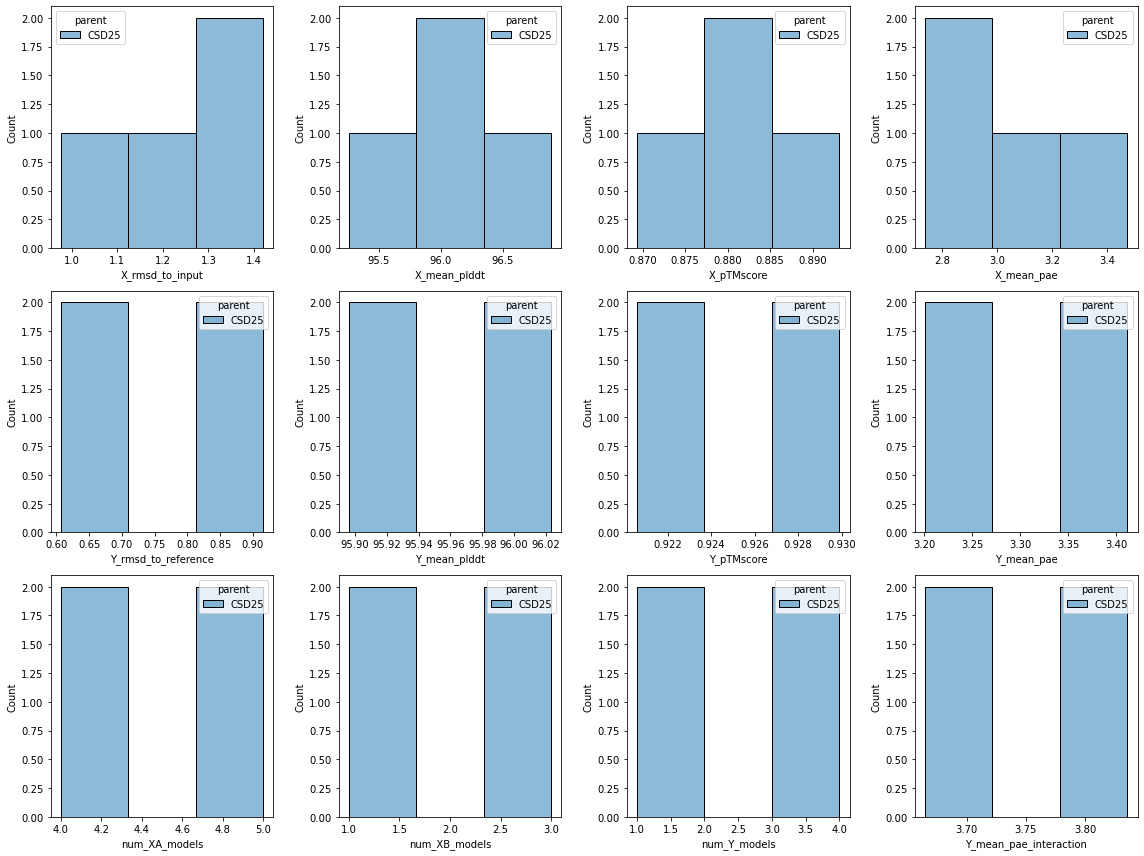

In [175]:
the_fig = histplot_df(
    df=CSD25_complete_full,
    cols=cols,
    hue="parent"
)

In [176]:
for combo in CSD25_complete_full['unique_combo'].values:
    copy_designs(CSD25_complete_full, combo, '05_selected/manual_filter_designs/')

In [181]:
CSD20_complete_full = complete_full.query("(num_Y_models >= 3 and parent == 'CSD20') or (num_XB_models >= 3 and parent == 'CSD20')")
with pd.option_context(
    'display.max_columns', None,
    # 'display.max_rows', None,
):
    display(CSD20_complete_full)

,Unnamed: 0,Unnamed: 0.1,X_mean_pae,X_mean_pae_interaction,X_mean_pae_intra_chain,X_mean_pae_intra_chain_A,X_mean_plddt,X_model,X_pTMscore,X_protomer,X_recycles,X_rmsd_to_input,X_seed,X_tol,X_type,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,designed_by,dslf_fa13,elapsed_time,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,lk_ball_wtd,mean_pae,mean_pae_interaction,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_plddt,model,omega,pTMscore,p_aa_pp,pro_close,rama_prepro,recycles,ref,rmsd_to_input,seed,tol,total_score,type,yhh_planarity,designed_by.1,mpnn_msd_design_area,mpnn_msd_temperature,parent,combo,mpnn_seq_id,unique_combo,num_Y_models,num_XA_models,num_XB_models
3279,3279,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.818815,NaN,2.742847,2.742847,95.634003,5,0.882699,A,3.0,1.202116,0,0.096957,monomer_ptm,2.905629,3.342816,3.409352,3.276280,2.415629,2.477396,2.353863,96.724335,1,0.931400,3.0,0.572136,0,0.232217,monomer_ptm,mpnn,0.0,3.869632,-4006.231681,1110.235868,-1204.727471,1289.445934,121.675265,5321.862738,2555.234043,-24.792994,-10.552242,-32.883287,-518.441297,-90.582814,2.818815,NaN,2.742847,2.742847,95.634003,5,115.667381,0.882699,-209.016897,0.000000,-195.013176,3.0,243.25032,1.202116,0,0.096957,575.685571,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,5511,mpnn_seq_0007,CSD20_5511_full_mpnn_seq_0007,1.0,2.0,4.0
3415,3415,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.184384,NaN,2.121341,2.121341,97.780411,5,0.913510,B,3.0,0.362545,0,0.053177,monomer_ptm,2.905629,3.342816,3.409352,3.276280,2.415629,2.477396,2.353863,96.724335,1,0.931400,3.0,0.572136,0,0.232217,monomer_ptm,mpnn,0.0,3.800934,-4006.231681,1110.235868,-1204.727471,1289.445934,121.675265,5321.862738,2555.234043,-24.792994,-10.552242,-32.883287,-518.441297,-90.582814,2.184384,NaN,2.121341,2.121341,97.780411,5,115.667381,0.913510,-209.016897,0.000000,-195.013176,3.0,243.25032,0.362545,0,0.053177,575.685571,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,5511,mpnn_seq_0007,CSD20_5511_full_mpnn_seq_0007,1.0,2.0,4.0
3350,3350,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,3.242774,NaN,3.146297,3.146297,94.796028,3,0.881462,A,3.0,0.988270,0,0.268014,monomer_ptm,2.912438,3.330975,3.427181,3.234768,2.408895,2.507448,2.310343,96.863457,3,0.939488,3.0,0.843170,0,0.100996,monomer_ptm,mpnn,0.0,3.989243,-3930.194303,1035.224161,-1232.277556,1237.244661,116.858139,5645.294214,2548.793860,-27.269420,-9.877140,-41.582627,-514.580653,-80.607855,3.242774,NaN,3.146297,3.146297,94.796028,3,97.414826,0.881462,-214.509851,0.000000,-194.741242,3.0,258.05266,0.988270,0,0.268014,745.696519,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,1411,mpnn_seq_0006,CSD20_1411_full_mpnn_seq_0006,3.0,1.0,5.0
3479,3479,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.536488,NaN,2.418459,2.418459,96.590805,5,0.900684,B,3.0,0.451288,0,0.053498,monomer_ptm,2.912438,3.330975,3.427181,3.234768,2.408895,2.507448,2.310343,96.863457,3,0.939488,3.0,0.843170,0,0.100996,monomer_ptm,mpnn,0.0,3.866695,-3930.194303,1035.224161,-1232.277556,1237.244661,116.858139,5645.294214,2548.793860,-27.269420,-9.877140,-41.582627,-514.580653,-80.607855,2.536488,NaN,2.418459,2.418459,96.590805,5,97.414826,0.900684,-214.509851,0.000000,-194.741242,3.0,258.05266,0.451288,0,0.053498,745.696519,monomer_ptm,0.000000e+00,mpnn,full,0.2,CSD20,1411,mpnn_seq_0006,CSD20_1411_full_mpnn_seq_0006,3.0,1.0,5.0
3708,3708,/pscratch/sd/b/broerman/04_fold_dimer_X/decoys...,2.755576,NaN,2.661271,2.661271,96.112061,3,0.899205,A,3.0,0.455408,0,0.200877,monomer_ptm,2.779620,3.200685,3.110862,3.290508,2.301043,2.235824,2.366261,96.922653,5,0.935080,3.0,0.509814,0,0.153695,monomer_ptm,mpnn,0.0,4.145609,-3991.968811,1167.510964,-1234.751521,1313.192890,133.216391,7562.197926,2

12it [00:00, 25.71it/s]


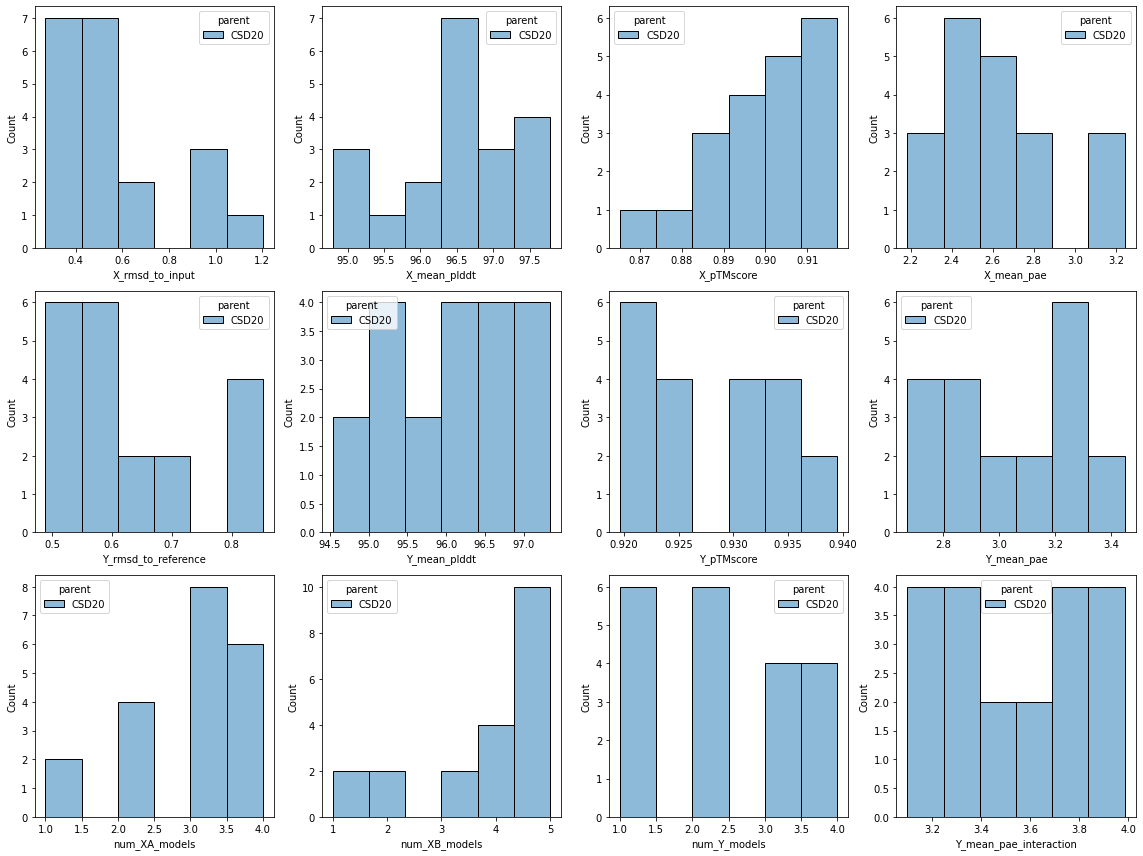

In [178]:
the_fig = histplot_df(
    df=CSD20_complete_full,
    cols=cols,
    hue="parent"
)

In [179]:
for combo in CSD20_complete_full['unique_combo'].values:
    copy_designs(CSD20_complete_full, combo, '05_selected/manual_filter_designs/')

# almost included 1411_full except for too many glycines